<div align='right'>
    Mathematics in Machine Learning (01TXGSM)<br>
    Politecnico di Torino - Academic Year 2020/21
</div>

<div align='center'> 
    <h1 style=font-size:2.5em>Predicting credit card defaults with machine learning algorithms</h1><br>
</div>

<div>
    <p style='text-align:left;'>
        Prof. Francesco Vaccarino<br>
        Prof. Mauro Gasparini
        <span style='float:right;'>
            Student: <a href='mailto:s292938@studenti.polito.it'>Leonardo Maggio - 292938</a>
        </span>
    </p>
</div>

<div align='center'> 
    <h1>Abstract</h1>
</div>

<div><p><br>
Financial institutions need to measure risks within their credit portfolios for regulatory requirements and for internal risk management. To meet these requirements financial institutions increasingly rely on models and algorithms to predict losses resulting from customers' defaults. Hence, developing sufficiently accurate and robust models is one of the major efforts of quantitative risk management groups within these institutions.<br><br>
The proposed research is one such effort to develop robust and efficient models for the credit default risk problem. Specifically, we study the mathematical foundation of some Machine Learning classification algorithms and develop them to predict default risk for credit card accounts.
</p></div>

In [1]:
from IPython.display import HTML

HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [57]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import KMeansSMOTE, SMOTE

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from pydotplus import graph_from_dot_data
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Table of Contents
1. [Introduction](#introduction)<br>
2. [Exploratory Data Analysis](#eda)<br>
    2.1 [Dataset Description](#description)<br>
    2.2 [Data Cleaning](#cleaning)<br>
    2.3 [Data Exploration](#exploration)<br>
    2.4 [Correlation Among Features](#correlation)<br>
    2.5 [Normality Check](#normality)<br>
3. [Data Preprocessing](#preprocessing)<br>
    3.1 [Handling Categorical Features](#one-hot)<br>
    3.2 [Dataset Partition](#train-test)<br>
    3.3 [Feature Scaling](#scaling)<br>
    3.4 [Dimensionality Reduction](#pca)<br>
    3.5 [Dealing with Class Imbalance](#imbalance)<br>
4. [Model Evaluation Methodology](#method)<br>
    4.1 [Validation](#validation)<br>
    4.2 [Performance Evaluation Metrics](#metrics)<br>
5. [Classification Models](#models)<br>
    5.1 [Logistic Regression](#logistic)<br>
    5.2 [Support Vector Machine](#svm)<br>
    5.3 [Tree-Based Methods](#tree)<br>
    5.4 [Models' Performance Results](#results)<br>
6. [Conclusion](#conclusion)<br>

    [References](#references)

<a id='introduction'></a>
# 1. Introduction
Beginning in 1990, the Taiwanese government allowed the formation of new banks. These new banks initially did business with real estate companies, but when the market became saturated they turned to the credit card business. In order to increase market share, these banks over-issued cash and credit cards to unqualified applicants. At the same time, most cardholders, irrespective of their repayment ability, overused credit card for consumption and accumulated heavy credit and cash–card debts. *Default* occurs when a credit card holder is unable to meet the legal obligation of repayment. The crisis caused the blow to consumer finance confidence and it has been a big challenge for both banks and cardholders [\[1\]](#yeh2009).

In a well-developed financial system, crisis management is on the downstream and risk prediction is on the upstream. The major purpose of risk prediction is to use financial information, such as business financial statement, customer transaction and repayment records, etc., to predict business performance or individual customers’ credit risk and to reduce the damage and uncertainty.

In this project, our job is to reliably predict who is likely to default. If so, the bank may be able to prevent the loss by providing the customer with alternative options (such as forbearance or debt consolidation, etc.). Hence, we build an automated model based on the information about the client and historical transactions, capable of identifying key factors and predicting a credit card default.

<a id='eda'></a>
# 2. Exploratory Data Analysis

<a id='description'></a>
## 2.1 Dataset Description
Our study is conducted on the *Default of credit card clients* dataset from the UCI machine learning repository [\[2\]](#uci). It gathers $30,000$ observations made by a bank in Taiwan on distinct credit card holders from April 2005 to September 2005. The dataset employs the binary variable `default.payment.next.month` as response variable. It indicates whether or not the credit card holders are defaulters next month ($\text{Yes}=1, \text{No}=0$). Then, the following 23 variables are used as explanatory variables. We report the official description from [\[2\]](#uci).
- Client personal information:
    1. `LIMIT_BAL`: Amount of given credit (in *New Taiwan* dollars): it includes both the individual consumer credit and his/her family (supplementary) credit.
    2. `SEX`: 1 = male; 2 = female.
    3. `EDUCATION`: 1 = graduate school; 2 = university; 3 = high school; 4 = others.
    4. `MARRIAGE`: Marital status, 1 = married; 2 = single; 3 = others.
    5. `AGE`: Age in years.   
- History of past payments from April to September 2005, i.e., the delay of the past payment referred to a specific month:
    6. `PAY_0`: Repayment status in September, 2005.
    7. `PAY_2`: Repayment status in August, 2005.
    8. `PAY_3`: Repayment status in July, 2005.
    9. `PAY_4`: Repayment status in June, 2005.
    10. `PAY_5`: Repayment status in May, 2005.
    11. `PAY_6`: Repayment status in April, 2005.   
 
 The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- Amount of bill statement (in *New Taiwan* dollars), i.e. a monthly report that credit card companies issue to credit card holders in a specific month:
    12. `BILL_AMT1`: Amount of bill statement in September, 2005.
    13. `BILL_AMT2`: Amount of bill statement in August, 2005.
    14. `BILL_AMT3`: Amount of bill statement in July, 2005.
    15. `BILL_AMT4`: Amount of bill statement in June, 2005.
    16. `BILL_AMT5`: Amount of bill statement in May, 2005.
    17. `BILL_AMT6`: Amount of bill statement in April, 2005.
- Amount of previous payment (in *New Taiwan* dollars):
    18. `PAY_AMT1`: Amount of previous payment in September, 2005.
    19. `PAY_AMT2`: Amount of previous payment in August, 2005.
    20. `PAY_AMT3`: Amount of previous payment in July, 2005.
    21. `PAY_AMT4`: Amount of previous payment in June, 2005.
    22. `PAY_AMT5`: Amount of previous payment in May, 2005.
    23. `PAY_AMT6`: Amount of previous payment in April, 2005.
    
In order to understand what the data looks like, we print some observations in the table below. The target `default.payment.next.month` is renamed `DEFAULT` to be short, while the `PAY_0` column is renamed `PAY_1`.

In [3]:
df = pd.read_csv('dataset/default of credit card clients.csv', index_col='ID')
df.rename(columns={'default.payment.next.month':'default'}, inplace=True)
df.rename(columns={'PAY_0': 'PAY_1'}, inplace=True)
df.rename(columns=lambda x: x.upper(), inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


The information on the dataset reported below show that there are no missing features for any of the $30,000$ samples.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   SEX        30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

<a id='cleaning'></a>
## 2.2 Data Cleanining
### 2.2.1 Client Personal Information
Below we print the description of the client personal information features. The `LIMIT_BAL`, `SEX`, and `AGE` attributes seem to be consistent with the description provided by [\[2\]](#uci), while `EDUCATION` and `MARRIAGE` have some undocumented categories. `EDUCATION` ranges from 0 to 6, while `MARRIAGE` starts at category 0.

In [5]:
df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500
std,129747.661567,0.489129,0.790349,0.521970,9.217904
min,10000.000000,1.000000,0.000000,0.000000,21.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000


In [8]:
df['EDUCATION'].value_counts().sort_index()

0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: EDUCATION, dtype: int64

In [9]:
df['MARRIAGE'].value_counts().sort_index()

0       54
1    13659
2    15964
3      323
Name: MARRIAGE, dtype: int64

The presence of errors in the dataset can be addressed by correcting the wrong attribute, or by deleting the rows associated with the error. We could take a conservative approach and group the undocumented categories into *others*, but since anomalous entries are relatively few ($399$, $1.33\%$ of the total number), we decide to eliminate them.

In [10]:
print(f"Dataset size before:\t{df.shape[0]}")
df = df.drop(df[df['MARRIAGE']==0].index)
df = df.drop(df[df['EDUCATION']==0].index)
df = df.drop(df[df['EDUCATION']==5].index)
df = df.drop(df[df['EDUCATION']==6].index)
print(f"Dataset size after:\t{df.shape[0]}")

# Alternative
# df['MARRIAGE'] = np.where(df['MARRIAGE']==0, 3, df['MARRIAGE'])
# df['EDUCATION'] = np.where(df['EDUCATION']==0, 4, df['EDUCATION'])
# df['EDUCATION'] = np.where(df['EDUCATION']==5, 4, df['EDUCATION'])
# df['EDUCATION'] = np.where(df['EDUCATION']==6, 4, df['EDUCATION'])

Dataset size before:	30000
Dataset size after:	29601


### 2.2.2 History of Past Payments
Below we print the description of the history of past payments features. The columns `PAY_n` range from -2 (undocumented) to 8, hence we believe they need to be rescaled to match the official description.

In [11]:
df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000,29601.000000
mean,-0.014932,-0.131313,-0.163440,-0.218303,-0.263978,-0.287558
std,1.124503,1.199642,1.199793,1.172220,1.136217,1.152206
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [12]:
pay_features = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
for p in pay_features:
    df.loc[df[p]<0, p] = -1
    df.loc[df[p]>=0, p] = df.loc[df[p]>=0, p] + 1
    df[p] = df[p].astype('int64')

### 2.2.3 Amount of Bill Statement and Previous Payment
Below we print the description of the features related to the amount of bill statement and the amount of previous payment. We do not find any anomalies.

In [13]:
df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,29601.000000,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000
mean,50957.432012,48942.189554,4.680320e+04,43122.554204,40235.545184,38858.449816
std,73370.242404,70923.985151,6.912389e+04,64196.383913,60699.344884,59519.893043
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3528.000000,2970.000000,2.652000e+03,2329.000000,1780.000000,1278.000000
50%,22259.000000,21050.000000,2.003500e+04,19005.000000,18091.000000,17118.000000
75%,66623.000000,63497.000000,5.983000e+04,54271.000000,50072.000000,49121.000000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [14]:
df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,29601.000000,2.960100e+04,29601.000000,29601.000000,29601.000000,29601.000000
mean,5649.560319,5.894788e+03,5198.415898,4828.659268,4795.032735,5181.326374
std,16568.264941,2.308919e+04,17580.914806,15711.057992,15244.217154,17657.260739
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1000.000000,8.250000e+02,390.000000,298.000000,259.000000,138.000000
50%,2100.000000,2.007000e+03,1800.000000,1500.000000,1500.000000,1500.000000
75%,5005.000000,5.000000e+03,4500.000000,4014.000000,4042.000000,4000.000000
max,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000


<a id='exploration'></a>
## 2.3 Data Exploration
In this section we show some graphs to better understand the relationship between the features and the target `DEFAULT`.

First, we see that the dataset we are dealing with is quite unbalanced, with only $6,636$ defaulters ($22.1\%$ of the total number). This is a rather relevant problem that needs to be addressed. If neglected, classification models will tend to focus on the majority class and overlook the minority class [\[3\]](#alam2021).

In [15]:
df['DEFAULT'].value_counts()

0    22996
1     6605
Name: DEFAULT, dtype: int64

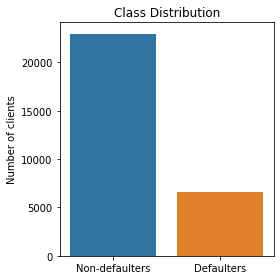

In [16]:
plt.figure(figsize = (4,4))
sns.countplot(x='DEFAULT', data=df)
plt.title('Class Distribution')
sns.set_color_codes('pastel')
plt.xticks([0,1],['Non-defaulters', 'Defaulters'])
plt.xlabel('')
plt.ylabel('Number of clients')
plt.tight_layout()
plt.show()

For the feature `LIMIT_BAL`, we draw a density map according to the default type, and the result is shown below on the left. It seems that when the given credit amount is approximately below $140,000$, the probability of default is greater than that of non-default. This suggests that those with lower credit limits are more likely to default, whereas those with higher credit limits are less likely to default. This observation makes sense as a higher credit limit is given to people with higher creditworthiness that have a lower likelihood to default.

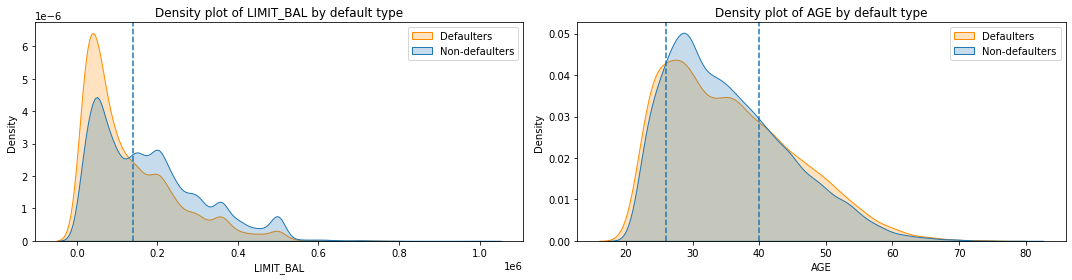

In [21]:
sns.set_color_codes('pastel')
fig, axs = plt.subplots(1, 2, figsize=(15,4))

class_0 = df.loc[df['DEFAULT'] == 0]['LIMIT_BAL']
class_1 = df.loc[df['DEFAULT'] == 1]['LIMIT_BAL']
axs[0].set_title('Density plot of LIMIT_BAL by default type')
sns.kdeplot(class_1, fill=True, label='Defaulters', color='darkorange', ax=axs[0])
sns.kdeplot(class_0, fill=True, label='Non-defaulters', ax=axs[0])
axs[0].axvline(0.14*1e6, 0, ls='--')
axs[0].legend()

class_0 = df.loc[df['DEFAULT'] == 0]['AGE']
class_1 = df.loc[df['DEFAULT'] == 1]['AGE']
axs[1].set_title('Density plot of AGE by default type')
sns.kdeplot(class_1, fill=True, label='Defaulters', color='darkorange', ax=axs[1])
sns.kdeplot(class_0, fill=True, label='Non-defaulters', ax=axs[1])
axs[1].axvline(26, 0, ls='--')
axs[1].axvline(40, 0, ls='--')
axs[1].legend()

fig.tight_layout()
plt.show()

For the feature `AGE`, we perform a similar visual analysis, as shown above on the right. The probability of non-default of age between approximately $25$ and $40$ is higher, which indicates that consumers in this age group are more capable of repaying credit card loans. This may be because their work and family tend to be stable without too much pressure.

The features `SEX`, `EDUCATION`, and `MARRIAGE` are plotted according to the target variable using histograms, as shown below. Whether it is male or female, the proportion of defaulters is in line with the general situation, and we can say the same for the categories of the other two features.

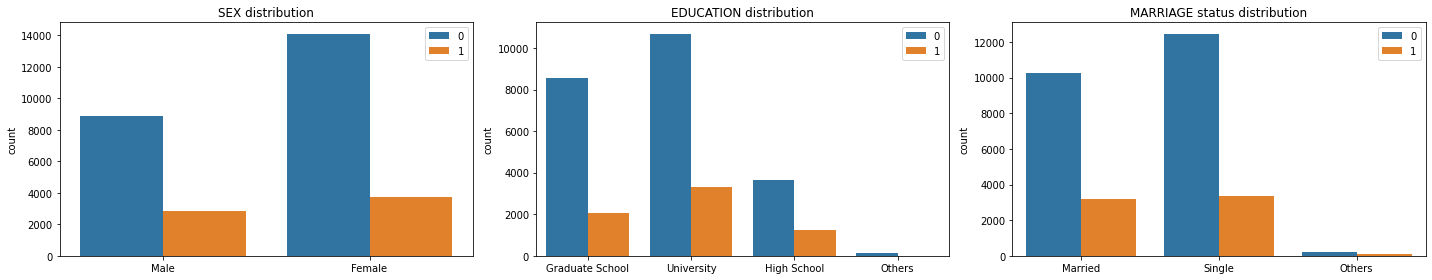

In [22]:
sns.set_color_codes('pastel')
fig, axs = plt.subplots(1, 3, figsize=(20,4))

axs[0].set_title('SEX distribution')
sns.countplot(x='SEX', hue='DEFAULT', data=df, ax=axs[0])
axs[0].set_xticklabels(['Male', 'Female'])
axs[0].set_xlabel('')
axs[0].legend()

axs[1].set_title('EDUCATION distribution')
sns.countplot(x='EDUCATION', hue='DEFAULT', data=df, ax=axs[1])
axs[1].set_xticklabels(['Graduate School', 'University', 'High School', 'Others'])
axs[1].set_xlabel('')
axs[1].legend()

axs[2].set_title('MARRIAGE status distribution')
sns.countplot(x='MARRIAGE', hue='DEFAULT', data=df, ax=axs[2])
axs[2].set_xticklabels(['Married', 'Single', 'Others'])
axs[2].set_xlabel('')
axs[2].legend()

fig.tight_layout()
plt.show()

The payment status feature set is shown below via boxplots. It can be seen that clients who delay payment by one month or less have fewer credit card defaults. In particular, the repayment status in September, i.e., `PAY_1`, holds a greater discriminatory power than the repayment status in the other months.

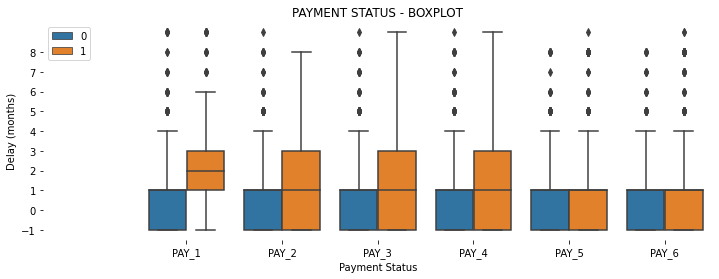

In [23]:
repayment = df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT']]
repayment = pd.melt(repayment, 
                    id_vars="DEFAULT",
                    var_name="Payment Status",
                    value_name='Delay (months)')

sns.set_color_codes('pastel')
plt.figure(figsize=(12,4))
sns.boxplot(y="Delay (months)", x="Payment Status", hue="DEFAULT", data=repayment)
plt.xlim([-1.5,5.5])
plt.ylim([-1.5,9.5])
plt.yticks(np.arange(-1,9))
plt.title('PAYMENT STATUS - BOXPLOT')
plt.legend()
plt.box(False)

<a id='correlation'></a>
## 2.4 Correlation Among Features
The considered dataset has many attributes, and the presence of strongly correlated features may lead to a drop in the performances of some classification algorithms. Indeed, there are some methods that assume the independence of the predictors and benefit from dimensionality reduction.

Pearson’s Correlation Coefficient $\rho$ helps us to find out the relationship between two variables, measuring the strength of association between them. It is calculated as the covariance between two features $X$ and $Y$ (numerator) divided by the product of their standard deviations (denominator):

$$\rho_{X,Y}=\frac{\text{Cov}(X,Y)}{\sigma_X\sigma_Y} \tag{2.1}$$

The value of Pearson’s Correlation Coefficient can be between $-1$ and $+1$.
- $+1$ means that they are highly correlated,
- $0$ means no correlation,
- $-1$ means that there is a negative correlation (inverse proportion).

Note that the Pearson’s correlation Coefficient is only able to capture linear trends, hence it might lead to a value of $0$ for strongly non-linearly correlated variables (e.g. quadratic trend).

Below we show only the lower half of the correlation matrix between the numeric features (diagonal excluded).

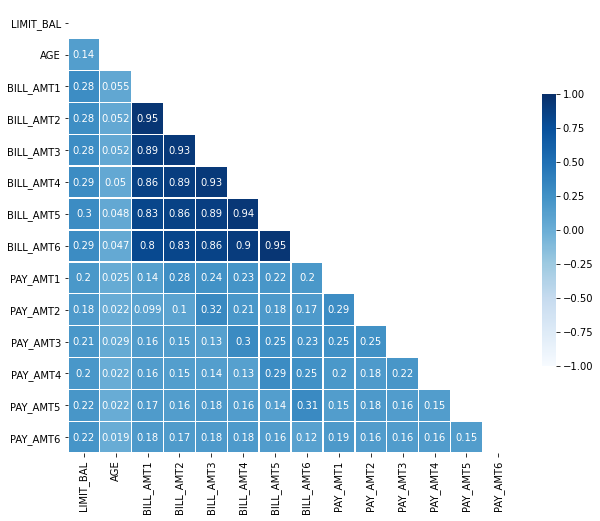

In [24]:
numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
corr = df[numeric].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, mask=mask, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cmap='Blues', cbar_kws={'shrink': .5}, annot=True, annot_kws={'size': 10})
cbar = ax.collections[0].colorbar

We note that there is a strong positive correlation between the `BILL_AMTn` features, which may indicate a redundancy of information. Hence, we report the scatter plots of these variables to highlight their interaction. The matrix below contains, for each combination of variables, a small scatterplot that displays the distribution of data points among the two variables considered, separated by the two classes. The linear trend confirms what the Pearson coefficient suggested, namely that the `BILL_AMTn` features encode rather similar information.

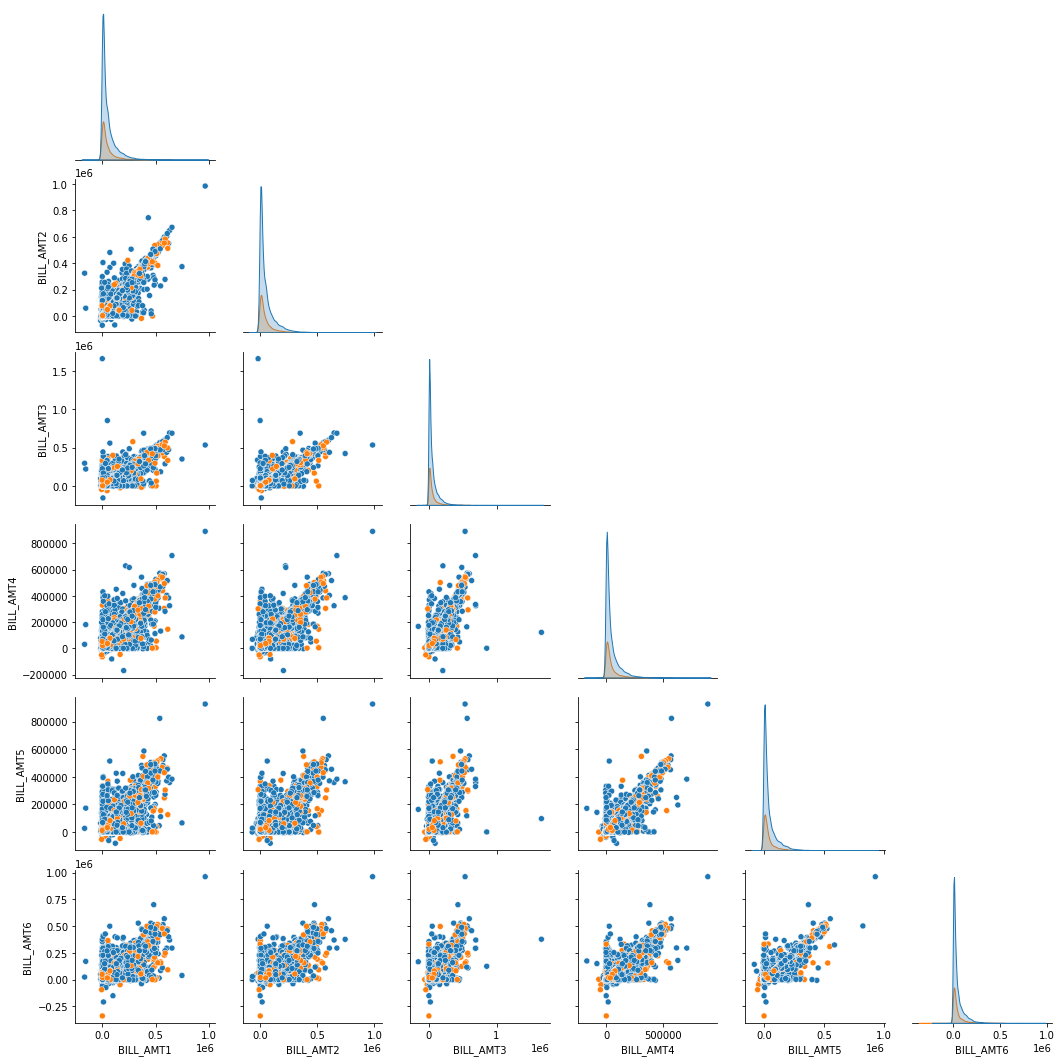

In [25]:
pair_plot = sns.pairplot(df[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','DEFAULT']], hue='DEFAULT', diag_kind='kde', corner=True)
pair_plot._legend.remove()

<a id='normality'></a>
## 2.5 Normality Check
Parametric statistical methods assume that the data have a known and specific distribution, often a Gaussian distribution. If we apply such methods on data from a different distribution, our findings may be misleading or plain wrong. To check whether our data are Gaussian, we use a graphical method called Quantile-Quantile (QQ) plot that allows us to give a qualitative evaluation. In a QQ plot, the quantiles of the independent variable are plotted against the expected quantiles of the normal distribution. If the variable is normally distributed, the dots in the QQ plot should fall along a 45 degree diagonal.

The following plots show that there is no evidence to believe that numerical features are normally distributed.

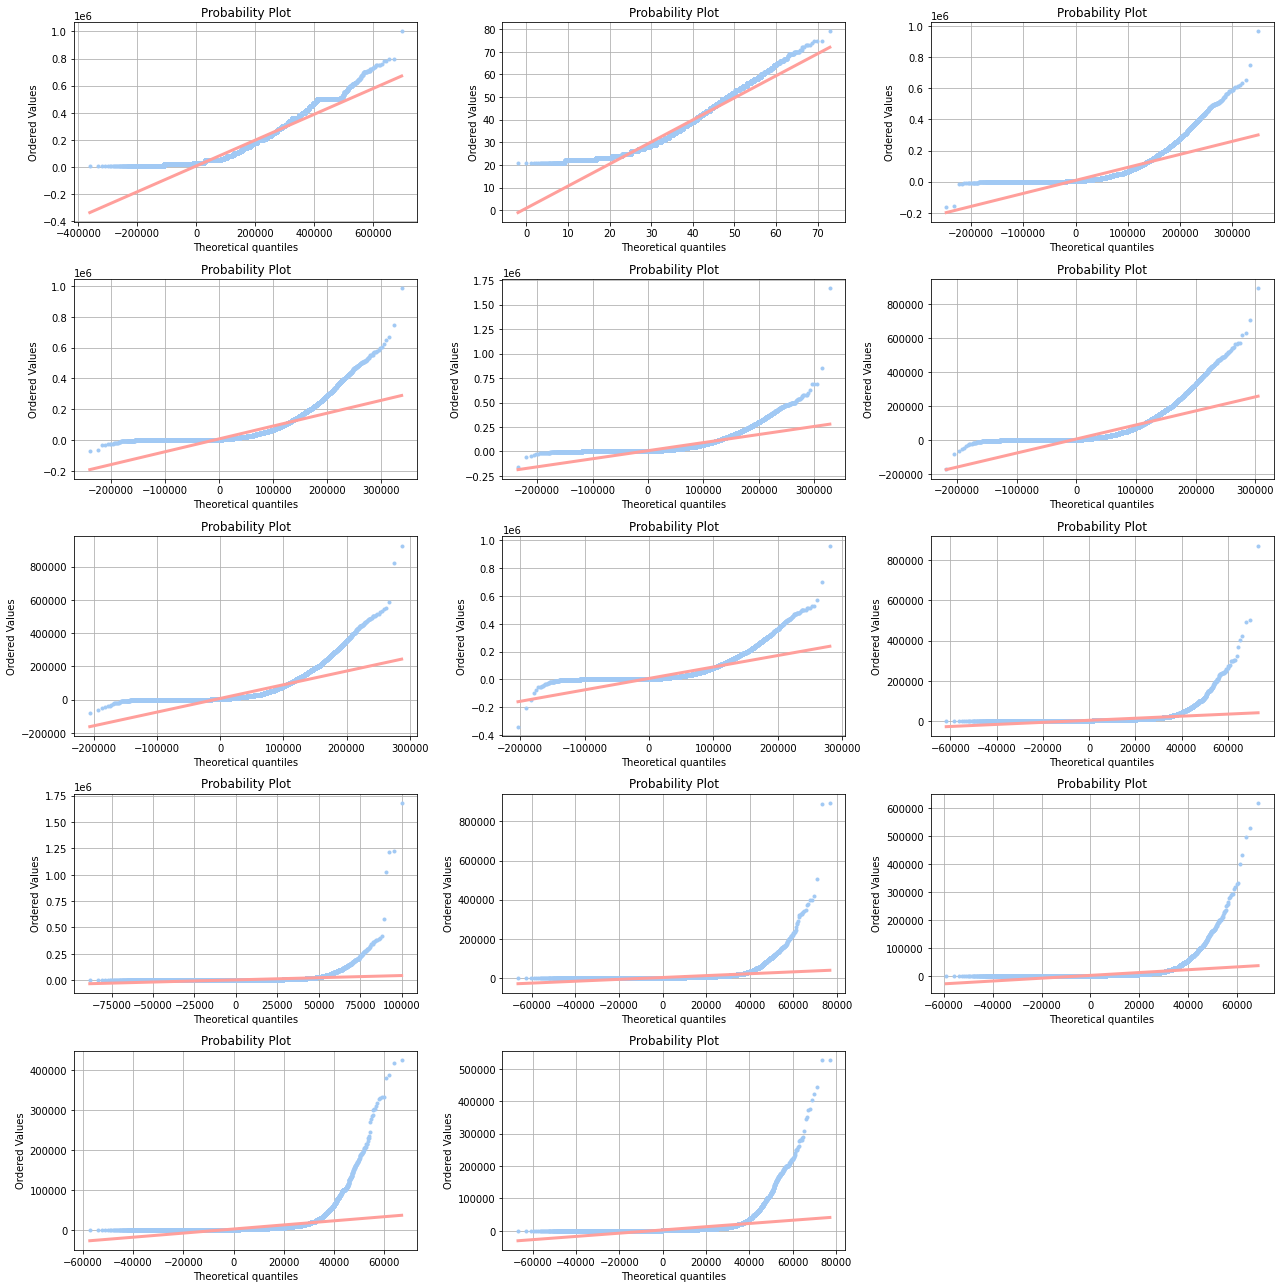

In [26]:
sns.set_color_codes('pastel')
fig, axs = plt.subplots(5, 3, figsize=(18,18))

numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
i, j = 0, 0
for f in numeric:
    if j == 3:
        j = 0
        i = i+1
    stats.probplot(df[f], 
                   dist='norm', 
                   sparams=(df[f].mean(), df[f].std()), 
                   plot=axs[i,j])
    axs[i,j].get_lines()[0].set_marker('.')
    
    axs[i,j].grid()
    axs[i,j].get_lines()[1].set_linewidth(3.0)
    j = j+1

fig.tight_layout()
axs[4,2].set_visible(False)
plt.show()

<a id='preprocessing'></a>
# 3. Data Preprocessing
The quality of the data and the amount of useful information that are contained are key factors that determine how well a machine learning algorithm can learn. Therefore, it is absolutely critical to ensure that we examine and preprocess our dataset before we feed it to a learning algorithm.

<a id='one-hot'></a>
## 3.1 Handling Categorical Features
The categorical features `EDUCATION`, `SEX`, and `MARRIAGE` are already encoded with integer numbers and could be fed to a machine learning algorithm. However, these are nominal features, for which it would be sub-optimal to assume an ordering. **One-hot encoding** allows us to remove any ordinal relationship, which would be meaningless between these categorical variables. The idea behind this approach is to create a new dummy feature for each unique value in the nominal feature column. Binary values can then be used to indicate the particular class of an example.

Although Scikit-Learn provides methods to perform one-hot encoding automatically, we decide to do the mapping of the features by hand, since there are few. In this way we mitigate the problem of *multicollinearity*, which occurs when there are highly correlated features. Thus, we create the following boolean columns and drop the old ones, `EDUCATION`, `SEX`, and `MARRIAGE`.
- `MALE`: 1 = male; 0 = female.
- `MARRIED`: 1 = married marital status; 0 = otherwise.
- `GRAD_SCHOOL`: 1 = graduate school level of education; 0 = otherwise.
- `UNIVERSITY`: 1 = university level of education; 0 = otherwise.
- `HIGH_SCHOOL`: 1 = high school level of education; 0 = otherwise.

Note that we do not lose any important information by removing a feature column, though; for example, we removed the column `EDUCATION=4` (others), but the feature information is still preserved, since if we observe
`GRAD_SCHOOL=0`, `UNIVERSITY=0` and `HIGH_SCHOOL=0`, it implies that the observation must be `OTHERS`.

In [27]:
df['GRAD_SCHOOL'] = (df['EDUCATION'] == 1).astype('category')
df['UNIVERSITY'] = (df['EDUCATION'] == 2).astype('category')
df['HIGH_SCHOOL'] = (df['EDUCATION'] == 3).astype('category')
df.drop('EDUCATION', axis=1, inplace=True)

df['MALE'] = (df['SEX'] == 1).astype('category')
df.drop('SEX', axis=1, inplace=True)

df['MARRIED'] = (df['MARRIAGE'] == 1).astype('category')
df.drop('MARRIAGE', axis=1, inplace=True)

df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,GRAD_SCHOOL,UNIVERSITY,HIGH_SCHOOL,MALE,MARRIED
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,24,3,3,-1,-1,-1,-1,3913.0,3102.0,...,0.0,0.0,0.0,0.0,1,False,True,False,False,True
2,120000.0,26,-1,3,1,1,1,3,2682.0,1725.0,...,1000.0,1000.0,0.0,2000.0,1,False,True,False,False,False
3,90000.0,34,1,1,1,1,1,1,29239.0,14027.0,...,1000.0,1000.0,1000.0,5000.0,0,False,True,False,False,False
4,50000.0,37,1,1,1,1,1,1,46990.0,48233.0,...,1200.0,1100.0,1069.0,1000.0,0,False,True,False,False,True
5,50000.0,57,-1,1,-1,1,1,1,8617.0,5670.0,...,10000.0,9000.0,689.0,679.0,0,False,True,False,True,True


<a id='train-test'></a>
## 3.2 Dataset Partition
To evaluate the generalization ability of the machine learning algorithms we are going to use, we separate the dataset into *training set* and *test set*, with the proportion 3:1. In particular, we apply stratification on the target variable `DEFAULT` to ensure that relative class frequencies are approximately preserved in both train and test split. We set `random_state = 24` to make the experiments repeatable.

In [28]:
y = df['DEFAULT']
X = df.drop('DEFAULT', axis=1, inplace=False)

In [29]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)
print('Training set shape: ', np.shape(X_train_raw))
print(f'- Defaulters:\t {len(y_train[y_train==1])}')
print(f'- Non-defaulters: {len(y_train[y_train==0])}')
print('Test set shape: ', np.shape(X_test_raw))
print(f'- Defaulters:\t {len(y_test[y_test==1])}')
print(f'- Non-defaulters: {len(y_test[y_test==0])}')

Training set shape:  (22200, 25)
- Defaulters:	 4954
- Non-defaulters: 17246
Test set shape:  (7401, 25)
- Defaulters:	 1651
- Non-defaulters: 5750


<a id='scaling'></a>
## 3.3 Features Scaling
The majority of machine learning and optimization algorithms behave much better if numerical features are on the same scale. Decision trees and random forests are two of the very few machine learning algorithms where there is no need to worry about feature scaling, as they are scale invariant [\[4\]](#raschka).

There are two common approaches to bringing different features onto the same scale: **normalization** and **standardization**. Normalization refers to the rescaling of the features to a range of $[0,1]$, which is a special case of *min-max scaling*:

$$X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} \tag{3.1}$$

Here, $X$ is a particular example, $X_{min}$ is the smallest value in a feature column, and $X_{max}$ is the largest value.

Using standardization, we center the feature columns at mean $\mu=0$ with standard deviation $\sigma=1$ so that the feature columns have the same parameters as a standard normal distribution, which makes it easier to learn the weights.

$$Z=\frac{X-\mu}{\sigma} \tag{3.2}$$

To provide a fair benchmark, we fit the statistics (min-max for normalization, mean and standard deviation for standardization) on the training set, and then transform both training and test sets according to them.

We compare the two approaches by showing the box-and-wiskers plots of the respective scaled data. Notice the high number of *outliers*. We do not eliminate any sample as an outlier because the literature on the dataset does not provide information on this [\[1\]](#yeh2009)[\[3\]](#alam2021)[\[5\]](#chen2021), and we lack knowledge about the domain.

While normalization suppress the effect of outliers, standardization mantains information about them. Since the technique we will apply shortly is sensitive to the presence of outliers, we decide to continue our study with the normalized data.

In [30]:
scaler = MinMaxScaler()
X_train_norm = X_train_raw.copy()
X_test_norm = X_test_raw.copy()

X_train_norm['LIMIT_BAL'] = scaler.fit_transform(X_train_raw['LIMIT_BAL'].values.reshape(-1, 1))
X_test_norm['LIMIT_BAL'] = scaler.transform(X_test_raw['LIMIT_BAL'].values.reshape(-1, 1))
X_train_norm['AGE'] = scaler.fit_transform(X_train_raw['AGE'].values.reshape(-1, 1))
X_test_norm['AGE'] = scaler.transform(X_test_raw['AGE'].values.reshape(-1, 1))
for i in range(1,7):
    X_train_norm['PAY_' + str(i)] = scaler.fit_transform(X_train_raw['PAY_' + str(i)].values.reshape(-1, 1))
    X_test_norm['PAY_' + str(i)] = scaler.transform(X_test_raw['PAY_' + str(i)].values.reshape(-1, 1))
    X_train_norm['BILL_AMT' + str(i)] = scaler.fit_transform(X_train_raw['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_test_norm['BILL_AMT' + str(i)] = scaler.transform(X_test_raw['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_train_norm['PAY_AMT' + str(i)] = scaler.fit_transform(X_train_raw['PAY_AMT' + str(i)].values.reshape(-1, 1))
    X_test_norm['PAY_AMT' + str(i)] = scaler.transform(X_test_raw['PAY_AMT' + str(i)].values.reshape(-1, 1))

In [31]:
scaler = StandardScaler()
X_train_std = X_train_raw.copy()
X_test_std = X_test_raw.copy()

X_train_std['LIMIT_BAL'] = scaler.fit_transform(X_train_raw['LIMIT_BAL'].values.reshape(-1, 1))
X_test_std['LIMIT_BAL'] = scaler.transform(X_test_raw['LIMIT_BAL'].values.reshape(-1, 1))
X_train_std['AGE'] = scaler.fit_transform(X_train_raw['AGE'].values.reshape(-1, 1))
X_test_std['AGE'] = scaler.transform(X_test_raw['AGE'].values.reshape(-1, 1))
for i in range(1,7):
    X_train_std['PAY_' + str(i)] = scaler.fit_transform(X_train_raw['PAY_' + str(i)].values.reshape(-1, 1))
    X_test_std['PAY_' + str(i)] = scaler.transform(X_test_raw['PAY_' + str(i)].values.reshape(-1, 1))
    X_train_std['BILL_AMT' + str(i)] = scaler.fit_transform(X_train_raw['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_test_std['BILL_AMT' + str(i)] = scaler.transform(X_test_raw['BILL_AMT' + str(i)].values.reshape(-1, 1))
    X_train_std['PAY_AMT' + str(i)] = scaler.fit_transform(X_train_raw['PAY_AMT' + str(i)].values.reshape(-1, 1))
    X_test_std['PAY_AMT' + str(i)] = scaler.transform(X_test_raw['PAY_AMT' + str(i)].values.reshape(-1, 1))

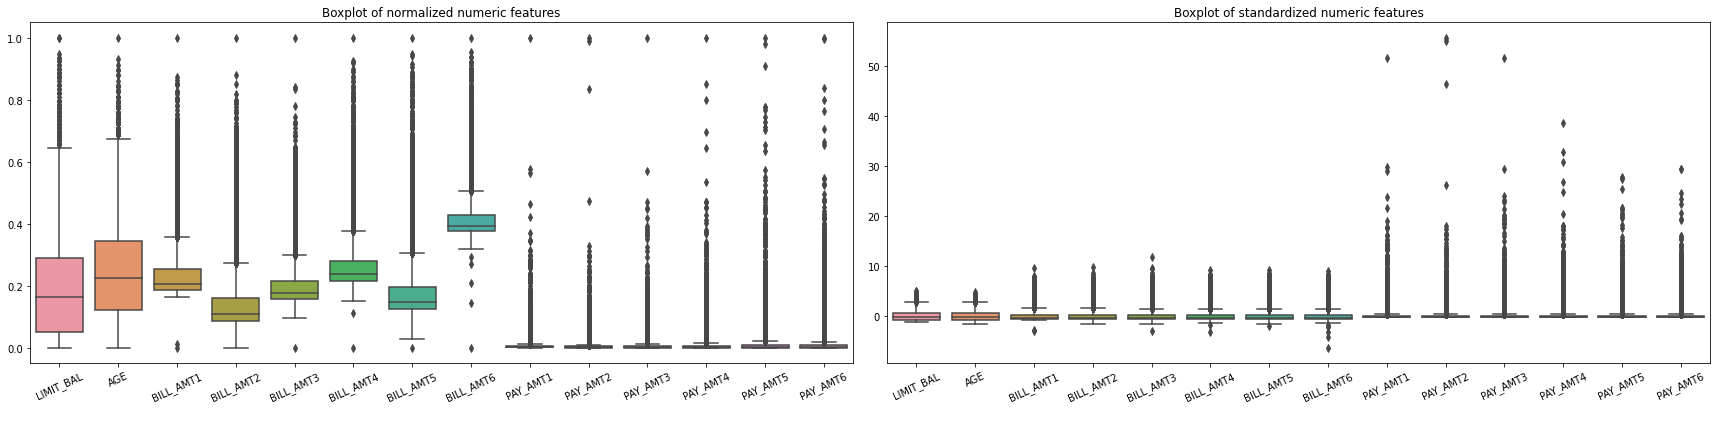

In [32]:
sns.set_color_codes('pastel')
numeric = ['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
fig, axs = plt.subplots(1, 2, figsize=(24,6))

sns.boxplot(data=X_train_norm[numeric], ax=axs[0])
axs[0].set_title('Boxplot of normalized numeric features')
axs[0].set_xticklabels(labels=numeric, rotation=25)
axs[0].set_xlabel(' ')

sns.boxplot(data=X_train_std[numeric], ax=axs[1])
axs[1].set_title('Boxplot of standardized numeric features')
axs[1].set_xticklabels(labels=numeric, rotation=25)
axs[1].set_xlabel(' ')

fig.tight_layout()
plt.show()

<a id='pca'></a>
## 3.4 Dimensionality Reduction
As we mentioned in [2.4](#correlation), many algorithms benefit from the removal of strongly correlated features, and in general from the reduction of the dimensionality of the data. The presence of many features leads to excessively complex models, which fit the parameters too closely with regard to the particular observations in the training set, but do not generalize well to new data. We say that these models have a *high variance* and are *overfitting* the training set. 

The problem of overfitting becomes even more serious in the case of the *K-means algorithm* due to the **curse of dimensionality**. The curse of dimensionality describes the phenomenon where the feature space becomes increasingly sparse for an increasing number of dimensions of a fixed-size training dataset. We can think of even the closest neighbors as being too far away in a high-dimensional space to give a good estimate.

Simpler models can be obtained by requiring fewer parameters to fit the data. In addition to a lower computation cost and better interpretability, we also get a better generalization ability. The dimensionality reduction process can be carried out by means of *feature selection* or *feature extraction*. Via feature selection, we select a subset of the original features, whereas in feature extraction, we derive information from the feature set to construct a new feature subspace. In the context of dimensionality reduction, feature extraction can be understood as an approach to data compression with the goal of maintaining most of the relevant information.

Now, one could manually discard the highly correlated features we found earlier. However, we decide to keep them to perform **Principal Component Analysis**, a feature extraction technique.

### 3.4.1 Pricipal Component Analysis in a Nutshell
Pricipal Component Analysis (PCA) is an unsupervised linear transformation technique that helps us to identify patterns in data based on the correlation between features. In a nutshell, PCA aims to find the directions of maximum variance in high-dimensional data and projects the data onto a new subspace with equal or fewer dimensions than the original one  [\[4\]](#raschka). The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum variance, given the constraint that the new feature axes are orthogonal to each other, as illustrated in the following figure.

<figure>
    <img src="images/pca.png" alt="Principal Component Analysis" style="width: 20em;">
    <figcaption style='text-align:center; font-size: 0.8em;'>Fig. 3.1 - Principal Compontents in a 2-dimensional example <a href='#raschka'>[4]</a>.</figcaption>
</figure>

In the preceding figure, $x_1$ and $x_2$ are the original feature axes, and $PC1$ and $PC2$ are the principal components.
### 3.4.2 PCA Derivation
Let $\mathbf{x}_1,...,\mathbf{x}_m$ be the $m$ sample vectors in $\mathbb{R}^d$ from our dataset. The problem of dimensionality reduction can often be seen as embedding the original data from $\mathbb{R}^d$ into a new space $\mathbb{R}^n$, whose dimensionality is much smaller ($n<d$) [\[6\]](#shalev).

PCA performs dimensionality reduction as a simple autoencoder, which carries out compression and recovery by linear transformations. The idea is to find a matrix $W\in\mathbb{R}^{n,d}$ that induces the mapping

$$\mathbf{x}\mapsto W\mathbf{x},\qquad\mathbf{x}\in\mathbb{R}^d,\text{ }W\mathbf{x}\in\mathbb{R}^n\text{ }(n<d)$$

and a second matrix $U\in\mathbb{R}^{d,n}$ that is able to recover each original vector $\mathbf{x}$ from its compressed version $\mathbf{y}=W\mathbf{x}$. In general, the exact recovery is impossible and PCA aims to find the linear transformations for which the differences between the recovered vectors $\mathbf{\tilde{x}}=U\mathbf{y}$ and the original vectors $\mathbf{x}$ are minimal in the least squared sense:

$$\underset{W\in\mathbb{R}^{n,d},\text{ }U\in\mathbb{R}^{d,n}}{\operatorname{argmin}}{\sum_{i=1}^{m}{\|\mathbf{x}_i-UW\mathbf{x}_i\|^2_2}} \label{opt_min}\tag{3.4}$$

The optimal solution $(U,W)$ of this problem takes the following form:
- the columns of $U$ are orthonormal: $U^\top U=\mathbb{I}_n\in\mathbb{R}^n$;
- $W=U^\top$.

Hence, we can write:

$$\underset{U\in\mathbb{R}^{d,n}: U^\top U=\mathbb{I}_n}{\operatorname{argmin}}{\sum_{i=1}^{m}{\|\mathbf{x}_i-UU^\top\mathbf{x}_i\|^2_2}}$$

It can be proven that:

$$\|\mathbf{x}-UU^\top\mathbf{x}\|^2=\|\mathbf{x}\|^2-\operatorname{tr}{(U^\top\mathbf{x}\mathbf{x}^\top U)}$$

where the trace $\operatorname{tr}$ of a matrix is the sum of its diagonal entries, i.e., a linear operator. This allows us to rewrite Equation (\ref{opt_min}) as the following maximization problem:

$$\underset{U\in\mathbb{R}^{d,n}: U^\top U=\mathbb{I}_n}{\operatorname{argmax}}{\operatorname{tr}{\Bigg( U^\top \sum_{i=1}^{m}{\mathbf{x}_i\mathbf{x}_i^\top}U\Bigg)}} \label{opt_max}\tag{3.5}$$

Now, we can define the **scatter matrix** $A=\sum_{i=1}^{m}{\mathbf{x}_i\mathbf{x}_i^\top}$, and, since this matrix is simmetric, it can be written using its spectral decomposition  $A=VDV^\top$, where $D$ is diagonal and $V^\top V=VV^\top=\mathbb{I}_n$. Here, the elements on the diagonal of $D$ are the eigenvalues of $A$, while the columns of $V$ are the corresponding eigenvectors. In particular, we can safely assume that the diagonal elements of $D$ are sorted by the largest, and are all positive because $A$ is semidefinite positive:

$$D_{1,1}\geq D_{2,2}\geq...\geq D_{d,d}\geq0$$

From these premises, we can claim that the solution of the optimization problem (\ref{opt_min}) is the matrix $U$ whose columns $\mathbf{u}_1,...,\mathbf{u}_n$ are the $n$ eigenvectors of the matrix $A$ corresponding to the largest $n$ eigenvalues, while $W=U^\top$.
### 3.4.3 Explained Variance
Notice that $\hat{\Sigma}=\frac{1}{m-1}A$ is the empirical covariance matrix, and can be put in (\ref{opt_max}) instead of $A$, because they are similar matrices and have the same trace. Therefore, PCA can be interpreted as a technique to find the directions of maximal variance, which are given by the *principal components*, i.e., the eigenvectors corresponding to the largest eigenvalues of $\hat{\Sigma}$.

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance). The eigenvalues define the magnitude of the eigenvectors, so, to select the $n$ most informative eigenvectors, we can plot the variance explained ratios of the eigenvalues.

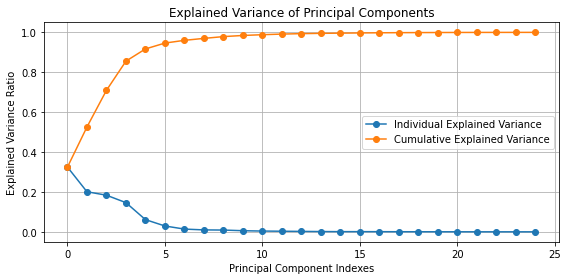

In [33]:
pc = len(X_train_norm.columns.values)
pca = PCA(n_components=pc)
pca.fit(X_train_norm)

sns.set_color_codes('pastel')
plt.figure(figsize = (8,4))
plt.grid()
plt.title('Explained Variance of Principal Components')
plt.plot(pca.explained_variance_ratio_, marker='o')
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.legend(["Individual Explained Variance", "Cumulative Explained Variance"])
plt.xlabel('Principal Component Indexes')
plt.ylabel('Explained Variance Ratio')
plt.tight_layout()
plt.show()

In [34]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
indexes = ['PC' + str(i) for i in range(1, pc+1)]
cumsum_df = pd.DataFrame(data=cumsum, index=indexes, columns=['var1'])
cumsum_df['var2'] = pd.Series([round(val, 4) for val in cumsum_df['var1']], index = cumsum_df.index)
cumsum_df['Cumulative Explained Variance'] = pd.Series(["{0:.2f}%".format(val * 100) for val in cumsum_df['var2']], index = cumsum_df.index)
cumsum_df = cumsum_df.drop(['var1','var2'], axis=1, inplace=False)
cumsum_df.T.iloc[:,:15]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
Cumulative Explained Variance,32.46%,52.56%,70.93%,85.57%,91.69%,94.63%,96.01%,96.98%,97.88%,98.44%,98.84%,99.14%,99.36%,99.51%,99.61%


The results shown in the graph above are astonishing, since using the first 5 principal components it is possible to capture more than 90% of the total variance. For our study, however, we choose to consider the first 12 principal components. In this way, more than 99% of the variance is explained, while the number of features has been halved.

We fit the PCA algorithm on the training set only, in order to avoid embedding information from the test set and to keep it unknown. After this, we project the test data onto the subspace generated by the first 12 principal components found by computing the covariance matrix on the training set.

In [35]:
pc = 12
pca = PCA(n_components=pc)
pca.fit(X_train_norm)
X_train = pd.DataFrame(pca.transform(X_train_norm))
X_test = pd.DataFrame(pca.transform(X_test_norm))
X_train.columns = ['PC' + str(i) for i in range(1, pc+1)]
X_test.columns = ['PC' + str(i) for i in range(1, pc+1)]
X_train.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-0.541856,-0.551393,-0.412480,0.122101,0.238448,0.715080,-0.118730,-0.217807,0.089929,0.010003,-0.012406,-0.002596
1,-0.499287,-0.532587,-0.456984,0.088489,-0.464270,0.046294,-0.005356,-0.012562,0.043945,0.027395,0.004628,0.006394
2,0.832777,-0.331479,-0.471075,-0.018672,0.173999,0.077012,-0.117121,-0.145521,-0.023793,0.052872,0.009305,-0.071040
3,0.863633,-0.282837,-0.492387,-0.059972,-0.293545,-0.108782,0.099432,-0.142524,0.090122,0.036494,0.002218,0.010245
4,-0.474527,-0.631709,0.548848,0.022170,-0.370284,0.012118,0.082537,-0.129728,-0.140121,-0.031074,0.067107,0.071883


<a id='imbalance'></a>
## 3.5 Dealing with Class Imbalance
We showed in [2.3](#exploration) that the dataset we are dealing with is unbalanced, as the *non-defaulter* examples are over-represented. Actually, class imbalance is a quite common problem when working with real-world data.

In [36]:
class_count = [y_train[y_train == 0].count(), y_train[y_train == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion')
class_count_df

Training set class proportion


,Number,Percentage
Non-defaulters,17246,77.68%
Defaulters,4954,22.32%


In our case, we could achieve almost $80\%$ accuracy by just predicting the majority class (non-defaulters) for all examples, without the help of a supervised machine learning algorithm. Thus, when we will fit classifiers on our datasets, it would make sense to focus on other metrics than accuracy when comparing different models. 

Aside from evaluating machine learning models, class imbalance influences a learning algorithm during model fitting itself. Since machine learning algorithms typically optimize a reward or cost function that is computed as a sum over the training examples that it sees during fitting, the decision rule is likely going to be biased toward the majority class.

We immediately exclude the option of collecting more data. One way to deal with imbalanced class proportions during model fitting is to assign a larger penalty to wrong predictions on the minority class. Other popular strategies for dealing with class imbalance include upsampling the minority class, downsampling the majority class, and the generation of synthetic training examples. Unfortunately, there is no universally best solution or technique that works best across different problem domains. Thus, in practice, it is recommended to try out different strategies on a given problem, evaluate the results, and choose the technique that seems most appropriate.

We decide to exclude the naïve methods of oversampling (undersampling), since they randomly duplicate (delete) data from the minority (majority) class, until the desired level is obtained. On the one hand, random undersampling does not allow to control which information is discarded, on the other hand random oversampling causes overfitting because the model is trained on many identical data. To mitigate these issues, we choose to adopt the Cluster Centroid method and the Synthetic Minority Oversampling Technique (SMOTE).

### 3.5.1 Cluster Centroid Undersampling
Our dataset provides enough samples in the minority class to allow us to perform undersampling. However, one major problem of using undersampling is that important information may be lost from the majority class, which can cause overly general rules. This cannot be afforded to develop the credit card default prediction model, especially for default samples. Hence, to overcome this problem, the Cluster Centroids method has been introduced in [\[7\]](#yen2009).

The idea of the Cluster Centroids method is to replace clusters of majority samples with the respective cluster centroids. A K-means algorithm is fitted to the data, and the number of clusters is set equal to the number of samples of the minority class. Then, the majority of samples from the clusters are entirely substituted by the sets of cluster centroids from K-means [\[8\]](#imbalanced_learn). Cluster Centroids contain the most representative variations of the majority class in which features values would be visualized at the center.<br><br>


<figure>
    <img src="images/cluster_centroids.png" alt="Cluster Centroid Undersampling" style="width: 35em;">
    <figcaption style='text-align:center; font-size: 0.8em;'>Fig. 3.2 - Cluster Centroid Undersampling <a href='#cc_img'>[9]</a >.</figcaption>
</figure>

In the dataframe below we show the result of undersampling. Now the training set is balanced and the number of *non-defaulters* equals the number of *defaulters*.

In [37]:
oversample = ClusterCentroids(random_state=24)
X_train_cc, y_train_cc = oversample.fit_resample(X_train, y_train)

In [38]:
class_count = [y_train_cc[y_train_cc == 0].count(), y_train_cc[y_train_cc == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion after Cluster Centroid Undersampling')
class_count_df

Training set class proportion after Cluster Centroid Undersampling


,Number,Percentage
Non-defaulters,4954,50.00%
Defaulters,4954,50.00%


### 3.5.2 Synthetic Minority Oversampling Technique
The Synthetic Minority Oversampling Technique (SMOTE) was proposed in [\[10\]](#smote) to avoid the risk of overfitting faced by random oversampling. Instead of merely replicating existing observations, the technique generates artificial samples. As shown in Figure 3.3, this is achieved by linearly interpolating a randomly selected minority observation and one of its neighboring minority observations. More precisely, SMOTE executes three steps to generate a synthetic sample. 
1. Firstly, it chooses a random minority observation $\vec{a}$.
2. Among its $k$ nearest minority class neighbors, instance $\vec{b}$ is selected.
3. Finally, a new sample $\vec{x}$ is created by randomly interpolating the two samples: $\vec{x}=\vec{a}+w\times(\vec{b}-\vec{a})$, where $w$ is a random weight in $[0,1]$.


<figure>
    <img src="images/smote1.png" alt="SMOTE interpolation" style="width: 55em;">
    <figcaption style='text-align:center; font-size: 0.8em;'>Fig. 3.3 - SMOTE linearly interpolates a randomly selected minority sample and one of its <i>k = 4</i> nearest neighbors <a href='#k-means-smote'>[11]</a >.</figcaption>
</figure>

In the dataframe below we show the result of SMOTE oversampling. Now the training set is balanced and the number of *defaulters* equals the number of *non-defaulters*.

In [39]:
oversample = SMOTE(random_state=24)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [40]:
class_count = [y_train_smote[y_train_smote == 0].count(), y_train_smote[y_train_smote == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion after SMOTE Oversampling')
class_count_df

Training set class proportion after SMOTE Oversampling


,Number,Percentage
Non-defaulters,17246,50.00%
Defaulters,17246,50.00%


However, the algorithm has some weaknesses dealing with imbalance and noise as illustrated in Figure 3.4. Since SMOTE randomly chooses a minority instance to oversample with uniform probability, densely populated minority areas are very likely to be further inflated, while sparsely populated minority areas remain sparse. Another major concern is that SMOTE is susceptible to noise generation. This happens because the algorithm does not recognize noisy minority samples, which are located among majority class instances, and still interpolate them with their nearest minority neighbor. Finally, the algorithm does not specifically enforce the decision boundary, while it has been argued that classifiers could benefit from the generation of samples closer to the class border.


<figure>
    <img src="images/smote2.jpg" alt="SMOTE weaknesses" style="width: 40em;">
    <figcaption style='text-align:center; font-size: 0.8em;'>Fig. 3.4 - Behavior of SMOTE in the presence of noise and within-class imbalance <a href='#k-means-smote'>[11]</a >.</figcaption>
</figure>

### 3.5.3 K-means SMOTE
The method proposed in [\[11\]](#k-means-smote) employs the simple and popular K-means clustering algorithm in conjunction with SMOTE oversampling in order to rebalance skewed datasets. It manages to avoid the generation of noise by oversampling only in safe areas (i.e., areas made up of at least 50\% of minority samples). Moreover, its focus is placed on both between-class imbalance and within-class imbalance, fighting the small disjuncts problem by inflating sparse minority areas.

K-means SMOTE consists of three steps: clustering, filtering, and oversampling.
1. In the clustering step, the input space is clustered into $k$ groups using K-means clustering.
2. The filtering step selects clusters for oversampling, retaining those with a high proportion of minority class samples. It then distributes the number of synthetic samples to generate, assigning more samples to clusters where minority samples are sparsely distributed.
3. Finally, in the oversampling step, SMOTE is applied in each selected cluster to achieve the target ratio of minority and majority instances.



<figure>
    <img src="images/smote3.png" alt="K-means SMOTE algorithm" style="width: 45em;">
    <figcaption style='text-align:center; font-size: 0.8em;'>Fig. 3.5 - K-means SMOTE oversamples safe areas and combats within-class imbalance <a href='#k-means-smote'>[11]</a >.</figcaption>
</figure>

In the dataframe below we show the result of K-means SMOTE oversampling. Now the training set is balanced and the number of *defaulters* equals the number of *non-defaulters*.

In [41]:
oversample = KMeansSMOTE(cluster_balance_threshold=0.00001, random_state=24)
X_train_ksmote, y_train_ksmote = oversample.fit_resample(X_train, y_train)

In [42]:
class_count = [y_train_ksmote[y_train_ksmote == 0].count(), y_train_ksmote[y_train_ksmote == 1].count()]
class_count_df = pd.DataFrame(data=class_count, index=['Non-defaulters', 'Defaulters'], columns=['Number'])
class_count_df['var2'] = pd.Series([round(val/class_count_df['Number'].sum(axis=0), 4) for val in class_count_df['Number']], index = class_count_df.index)
class_count_df['Percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in class_count_df['var2']], index = class_count_df.index)
class_count_df = class_count_df.drop(['var2'], axis=1, inplace=False)
print('Training set class proportion after K-means SMOTE Oversampling')
class_count_df

Training set class proportion after K-means SMOTE Oversampling


,Number,Percentage
Non-defaulters,17246,49.99%
Defaulters,17252,50.01%


<a id='method'></a>
# 4. Model Evaluation Methodology
<a id='validation'></a>
## 4.1 Validation
One of the key steps in building a machine learning model is to estimate its performance on data that the model has not seen before. For this reason, in [3.2](#train-test) we have split our initial dataset into separate training and test datasets. The former will be used for model training, and the latter to estimate its generalization performance. This approach is commonly known as **holdout** method.

However, in typical machine learning applications, we are also interested in tuning and comparing different parameter settings to further improve the performance for making predictions on unseen data. But, if
we reuse the same test dataset over and over again during this process, it will become part of our training data and thus the model will be more likely to overfit. A validation set could be held out of the training set, to evaluate on it the performance of the model. However, this is not recommended because performance estimation may be sensitive to how we partition the training set.

### 4.1.1 K-Fold Cross-Validation
Instead of holdout, a more robust technique for model tuning is **k-fold cross-validation**, where we repeat the holdout method $k$ times on $k$ subsets of the training data. In particular, we randomly split the training dataset into $k$ folds without replacement, where $k–1$ folds are used for the model training, and one fold is used for performance evaluation. We then calculate the average performance of the models based on the different independent test folds to obtain a performance estimate that is less sensitive to the sub-partitioning of the training data compared to the holdout method.


<figure>
    <img src="images/k-fold-cv.png" alt="10-fold Cross Validation" style="width: 40em;">
    <figcaption style='text-align:center; font-size: 0.8em;'>Fig. 4.1 - Example of k-fold cross-validation with <i>k = 10</i> <a href='#raschka'>[4]</a >.</figcaption>
</figure>

Once we have found satisfactory hyperparameter values, we can retrain the model on the complete training dataset and obtain a final performance estimate using the independent test dataset. The rationale behind fitting a model to the whole training dataset after k-fold cross-validation is that providing more training examples to a learning algorithm usually results in a more accurate and robust model.

Since k-fold cross-validation is a resampling technique without replacement, the advantage of this approach is that each example will be used for training and validation (as part of a test fold) exactly once, which yields a lower-variance estimate of the model performance than the holdout method.

A good standard value for $k$ in k-fold cross-validation is $10$ [\[12\]](#cv10). However, since we are working with a large dataset, we can choose a smaller value for $k$, for example $k=5$, and still obtain an accurate estimate of the average performance of the model while reducing the computational cost of refitting and evaluating the model on the different folds.

As before, stratification is applied to ensure that each fold is representative of the class proportions in the training dataset.

<a id='metrics'></a>
## 4.2 Performance Evaluation Metrics
Classification assessment metrics compare the true class membership of each observation with the prediction of the classifier. To illustrate the alignment of binary predictions with the true distribution, a **confusion matrix** can be constructed.

|            | Predicted Negative | Predicted Positive |
|:----------:|:-------------:|:-------------:|
| **Actual Negative** |       TN      |       FP      |
| **Actual Positive** |       FN      |       TP      |

The following terminology is often used when referring to the counts tabulated in a confusion matrix:
- True positive (TP), which corresponds to the number of positive examples correctly predicted by the classification model.
- False negative (FN), which corresponds to the number of positive examples wrongly predicted as negative by the classification model.
- False positive (FP), which corresponds to the number of negative examples wrongly predicted as positive by the classification model.
- True negative (TN), which corresponds to the number of negative examples correctly predicted by the classification model.

Predictive **accuracy** is the performance measure generally associated with machine learning algorithms and is defined as:

$$\text{Accuracy} = \frac{TP+TN}{TP+FP+TN+FN} \tag{4.1}$$

Since the accuracy measure treats every class as equally important, it may
not be suitable for analyzing imbalanced data sets, where the rare class is considered more interesting than the majority class [\[13\]](#tan2016).

**Precision** and **recall** are two widely used class-specific metrics employed in applications where successful detection of one of the classes is considered more significant than detection of the other class.

$$\text{Precision, }p = \frac{TP}{TP+FP} \tag{4.2}$$

$$\text{Recall, }r = \frac{TP}{TP+FN} \tag{4.3}$$

- Precision indicates how many of the positive predictions are correct. The higher the precision is, the lower the number of false positive errors committed by the classifier.
- Recall measures how many positive instances are correctly classified as such. Classifiers with large recall have very few positive examples misclassified as the negative class.

Building a model that maximizes both precision and recall is the key challenge of classification algorithms. Hence, these two metrics are usually summarized into another metric known as the F1-score.

$$\text{F1-score}=\frac{2}{\frac{1}{r}+\frac{1}{p}}=\frac{2rp}{r+p} \tag{4.4}$$

In principle, F1 represents a harmonic mean between recall and precision, and tends to be closer to the smaller of the two numbers. Hence, a high value ensures that both precision and recall are reasonably high.

### 4.2.1 Precision-Recall Curve
In a classification problem, we may decide to predict the class values directly, or the probabilities for each class instead. The reason for this is to provide the capability to choose and even calibrate the *threshold* for how to interpret the predicted probabilities. For example, a default might be to use a threshold of $0.5$, meaning that a probability in $[0.0, 0.49]$ is a negative outcome, and a probability in $[0.5, 1.0]$ is a positive outcome. This threshold can be adjusted to tune the behavior of the model for a specific problem. An example would be to reduce more of one or another type of error.

A *precision-recall* (PR) curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds. We use it to explore the trade-off between the well-classified positive examples and the number of misclassified negative examples.

<figure>
    <img src="images/pr_curve.png" alt="Precision-Recall Curve" style="width: 25em;">
    <figcaption style='text-align:center; font-size: 0.8em;'>Fig. 4.2 - Precision-Recall Curve Plot.</figcaption>
</figure>

Together with the PR curve, we also plot a horizontal line with the value of the ratio of positive cases in the dataset. It indicates the performance of a *no-skill classifier*, i.e., one that predict a random class in all cases. A model with perfect skill is depicted as a point at $(1,1)$. A skilful model is represented by a curve that bows towards $(1,1)$ above the flat line of no skill.

Besides, the area under the PR curve (AUC) is a good way to get a score for the general performance of a classifier and to compare it to that of another classifier [\[14\]](#ch8). Noting that the PR space is a unit square, it can be clearly seen that the AUC for a classifier $f$ is such that $\operatorname{AUC}(f)\in[0,1]$, with the upper bound attained for a perfect classifier (one with $p=1$ and $r=1$).

<a id='models'></a>
# 5. Classification Models
In this section, we present different supervised learning algorithms with their mathematical details, and we use them on our dataset to build a classification model that is able to predict credit card defaults in the next month.

<a id='logistic'></a>
## 5.1 Logistic Regression
### 5.1.1 Introduction to Generalized Linear Models
Generalized Linear Models (GLM) are a broad class of models that provide a unifying framework for many commonly used statistical techniques, such as the linear regression. They are characterized by the following three components [\[15\]](#agresti).
- The *random component* identifies the response variable $Y$ and assumes a probability distribution for it. Standard GLMs treat the $m$ observations on $Y$ as independent, and we denote those observations by $(y_1,..., y_m)$.
- The *linear predictor* specifies the explanatory variables. The name reflects that the variables enter linearly as predictors on the right-hand side of the model equation, in the form
$$\beta_0+\beta_1 x_1+...+\beta_n x_n=\mathbf{x}^\top\mathbf{\beta}$$
- The *link function* specifies a function of $\mathbb{E}[Y]$ that the GLM relates to the linear predictor.

Hence, in a GLM the expected response for a given feature vector
$\mathbf{x}=[x_1,...,x_n]^\top$ is of the form

$$\mathbb{E}[Y|X=\mathbf{x}]=h(\mathbf{x}^\top\mathbf{\beta})\tag{5.1}$$

for some *activation function* $h$, which is the inverse of the link function [\[16\]](#kroese).

### 5.1.2 The Logistic Model
In our case, the response `DEFAULT` falls into one of two categories, $\text{Yes}=1, \text{No}=0$, thus we assume a Bernoulli distribution for $Y$. Rather than modeling this response $Y$ directly, *logistic regression* models the probability that $Y$ belongs to a particular category using the *logistic function* as activation function $h$

$$P(Y_i=1|X=\mathbf{x}_i)=h(\mathbf{x}_i^\top\mathbf{\beta})=\frac{e^{\mathbf{x}_i^\top\mathbf{\beta}}}{1+e^{\mathbf{x}_i^\top\mathbf{\beta}}} \label{logistic_function}\tag{5.2}$$

To fit the model (\ref{logistic_function}), we use in the next section the *maximum likelihood* method. Large values of $\mathbf{x}_i^\top\mathbf{\beta}$ lead to a high probability that $Y_i=1$, and small values of $\mathbf{x}_i^\top\mathbf{\beta}$ cause $Y_i$ to be $0$ with high probability. The logistic function will always produce an S-shaped curve of the form depicted in Figure 5.1 (right), and so regardless of the value of $X$, we will obtain a sensible prediction.<br><br>

<figure>
    <img src="images/logistic.png" alt="Logistic Regression" style="width: 45em;">
    <figcaption style='text-align:center; font-size: 0.8em;' size>Fig. 5.1 - Classification on a simulated dataset. Left: estimated probability of default using linear regression. Some estimated probabilities are negative! The orange ticks indicate the 0/1 values coded for default (No or Yes). Right: Predicted probabilities of default using logistic regression. All probabilities lie between 0 and 1 <a href='#james'>[17]</a>.</figcaption>
</figure>

After a bit of manipulation of (\ref{logistic_function}), we find that

$$\frac{P(Y_i=1|X=\mathbf{x}_i)}{1-P(Y_i=1|X=\mathbf{x}_i)}=e^{\mathbf{x}_i^\top\mathbf{\beta}} \label{odds}\tag{5.3}$$

where the left-hand side is called the *odds*, and can take on any value between $0$ and $\infty$. By taking the logarithm of both sides of (\ref{odds}), we see that the logistic regression model (\ref{logistic_function}) has a *logit* that is linear in $X$

$$\log{\Bigg(\frac{P(Y_i=1|X=\mathbf{x}_i)}{1-P(Y_i=1|X=\mathbf{x}_i)}\Bigg)}=\mathbf{x}_i^\top\mathbf{\beta} \label{logit}\tag{5.4}$$

### 5.1.3 Estimating the Regression Coefficients
The coefficient vector $\mathbf{\beta}=[\beta_1,...,\beta_n]^\top$ is unknown, and must be estimated based on the available training data. We use the maximum likelihood method to find $\hat{\beta}$ such that, plugging this estimate into the model given in (\ref{logistic_function}), yields a number close to one for all individuals who defaulted, and a number close to zero for all individuals who did not. This intuition can be formalized using the *likelihood function*:

$$\mathcal{L}(\mathbf{\beta})=\prod_{i=1}^{m}{[h(\mathbf{x}_i^\top\mathbf{\beta})]^{y_i}[1-h(\mathbf{x}_i^\top\mathbf{\beta})]^{1-y_i}} \label{likelihood}\tag{5.5}$$

Maximizing the log-likelihood $\log{\mathcal{L}(\mathbf{\beta})}$ with respect to $\mathbf{\beta}$ gives the maximum likelihood estimator of $\mathbf{\beta}$. In a supervised learning framework, this is equivalent to minimizing:

$$-\frac{1}{m}\log{\mathcal{L}(\mathbf{\beta})}=-\frac{1}{m}\sum_{i=1}^{m}{[y_i\log{h(\mathbf{x}_i^\top\mathbf{\beta})}+(1-y_i)\log{(1-h(\mathbf{x}_i^\top\mathbf{\beta}))}]} \label{cross-entropy}\tag{5.6}$$

Notice that we can interpret (\ref{cross-entropy}) as the *binary cross-entropy training loss* associated with comparing a true conditional probability density function (pdf) with an approximated pdf. 

Minimizing (\ref{cross-entropy}) in terms of $\mathbf{\beta}$ actually constitutes a *convex* optimization problem, which can be solved computing the gradient and the Hessian of (\ref{cross-entropy}) and then applying an iterative process, like the Newton's method.

<a id='logistic-selection'></a>
### 5.1.4 Model Selection
In our study, we use the logistic regression model featured in the *Scikit-learn* library [\[18\]](#sklearn). Here, $\mathscr{l}_2$ regularization is applied by default, which is common in machine learning but not in statistics. 

$$\frac{\lambda}{2}\mathbf{\beta}^\top\mathbf{\beta} \label{l2}\tag{5.6}$$

Adding a regularization term to the cost function allows us to tune the complexity of the model, as it penalizes extreme weight values during model training. Via the regularization parameter, $\lambda$, we can then control how well we fit the training data, while keeping the weights small. By increasing the value of $\lambda$, we increase the regularization strength.

The `LogisticRegression` class in Scikit-learn implements the parameter `C` as the inverse of the regularization term $\lambda$. Consequently, we can specify a stronger regularization by adopting smaller values of `C`.

Therefore, we perform cross-validated grid-search over the following parameter grid to find the best configuration for our logistic regression model to use to predict the test set.

```python
params = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}
```

In [43]:
def plot_test_scores(model, oversample, plot):
    if oversample == 'raw':
        X_test_s = X_test_norm.copy()
    else:
        X_test_s = X_test.copy()
    y_pred = model.predict(X_test_s)
    test_acc = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    test_auc = auc(recall, precision)
    test_f1 = f1_score(y_test, y_pred)
    
    print("Test Scores:")
    print(f"- Accuracy:\t{test_acc}")
    print(f"- Recall:\t{test_recall}")
    print(f"- Precision:\t{test_precision}")
    print(f"- F1-score:\t{test_f1}")
    print(f"- AUC:\t\t{test_auc}")
    
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(15,4))
        
        tmp = pd.DataFrame({'Feature': X_test_s.columns, 
                            'Feature importance': model.best_estimator_.feature_importances_})
        tmp = tmp.sort_values(by='Feature importance', ascending=False)
        s = sns.barplot(x='Feature', y='Feature importance', data=tmp, ax=axs[0])
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
        
        plot_confusion_matrix(model, X_test_s, y_test, cmap=plt.cm.Blues, normalize='true', ax=axs[1])
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plot_precision_recall_curve(model, X_test_s, y_test, ax=axs[2])
        plt.axhline(no_skill, 0, ls='--', label='No Skill')
        plt.ylim([-0.05, 1.05])
        axs[2].legend(loc = 'upper right')
        plt.show()
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10,4))
        plot_confusion_matrix(model, X_test_s, y_test, cmap=plt.cm.Blues, normalize='true', ax=axs[0])
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plot_precision_recall_curve(model, X_test_s, y_test, ax=axs[1])
        plt.axhline(no_skill, 0, ls='--', label='No Skill')
        plt.ylim([-0.05, 1.05])
        axs[1].legend(loc = 'upper right')
        plt.show()
    
    return test_acc, test_recall, test_precision, test_f1, test_auc

def pipeline(model, params, oversample=None, plot=False):
    if oversample:
        if oversample == 'raw':
            X_train_s = X_train_norm.copy()
            y_train_s = y_train.copy()  
        else:
            X_train_s, y_train_s = oversample.fit_resample(X_train, y_train)
    else:
        X_train_s = X_train.copy()
        y_train_s = y_train.copy()
    
    gs = GridSearchCV(estimator = model,
                      param_grid = params,
                      scoring = 'f1',
                      cv = 5, 
                      n_jobs = -1,
                      verbose = True)
    gs.fit(X_train_s, y_train_s)
    print(f"Best parameters:\t{gs.best_params_}")
    print(f"Best validation score:\t{gs.best_score_}")
    
    test_scores = plot_test_scores(gs, oversample, plot)
    
    return gs.best_estimator_, test_scores

In [44]:
oversample_method = ['raw',
                     None, 
                     SMOTE(random_state=24),
                     KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=24),
                     ClusterCentroids(random_state=24)]
oversample_names = ['Raw data', 
                    'PCA', 
                    'PCA + SMOTE oversampling', 
                    'PCA + KMeansSMOTE oversampling', 
                    'PCA + ClusterCentroids oversampling']
scores_lr = {'Accuracy' : [float for i in range(len(oversample_method))],
             'Recall' : [float for i in range(len(oversample_method))],
             'Precision' : [float for i in range(len(oversample_method))], 
             'F1-score' : [float for i in range(len(oversample_method))],
             'AUC' : [float for i in range(len(oversample_method))],}

Logistic Regression with Raw data
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.28283357308711105
Test Scores:
- Accuracy:	0.8047561140386434
- Recall:	0.19382192610539067
- Precision:	0.7373271889400922
- F1-score:	0.3069544364508393
- AUC:		0.5554948385658438


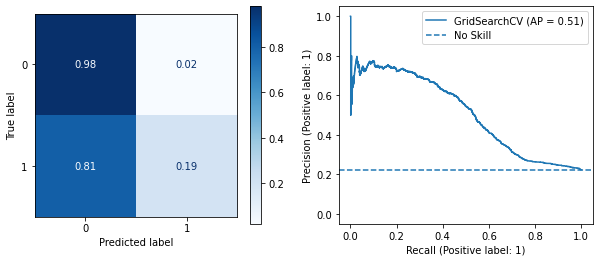

Logistic Regression with PCA
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.27924371052935976
Test Scores:
- Accuracy:	0.8042156465342521
- Recall:	0.19200484554815264
- Precision:	0.7337962962962963
- F1-score:	0.3043686989918387
- AUC:		0.5530235272794735


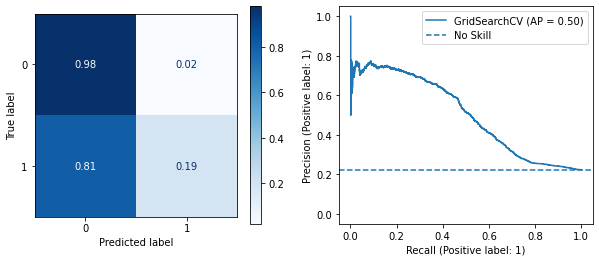

Logistic Regression with PCA + SMOTE oversampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 1.0}
Best validation score:	0.663015565520895
Test Scores:
- Accuracy:	0.6319416295095257
- Recall:	0.6795881284070261
- Precision:	0.3382574615616521
- F1-score:	0.45169082125603865
- AUC:		0.5446612087122137


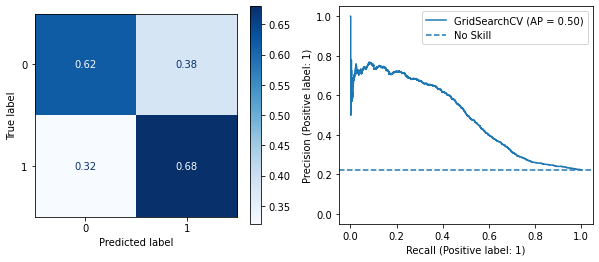

Logistic Regression with PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 100.0}
Best validation score:	0.7326117210632841
Test Scores:
- Accuracy:	0.7247669233887313
- Recall:	0.3634161114476075
- Precision:	0.37831021437578816
- F1-score:	0.3707136237256719
- AUC:		0.44186708130110464


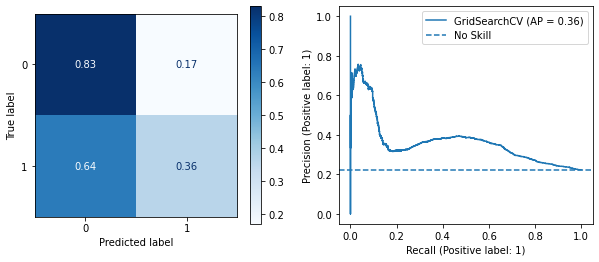

Logistic Regression with PCA + ClusterCentroids oversampling
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters:	{'C': 1.0}
Best validation score:	0.6513124599884605
Test Scores:
- Accuracy:	0.5987028779894609
- Recall:	0.6650514839491217
- Precision:	0.312375533428165
- F1-score:	0.4250871080139373
- AUC:		0.5260733249296918


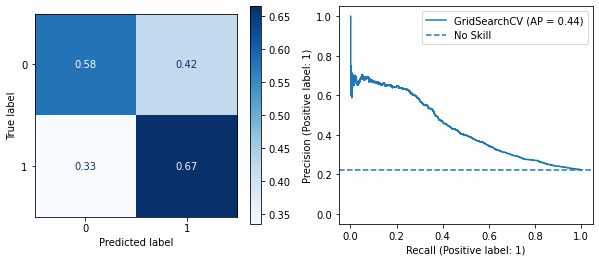

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.804756,0.193822,0.737327,0.306954,0.555495
PCA,0.804216,0.192005,0.733796,0.304369,0.553024
PCA + SMOTE oversampling,0.631942,0.679588,0.338257,0.451691,0.544661
PCA + KMeansSMOTE oversampling,0.724767,0.363416,0.378310,0.370714,0.441867
PCA + ClusterCentroids oversampling,0.598703,0.665051,0.312376,0.425087,0.526073


In [45]:
params_lr = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}
for idx, oversample in enumerate(oversample_method):
    print(f"Logistic Regression with {oversample_names[idx]}")
    _, scores = pipeline(LogisticRegression(random_state=24),
                         params_lr,
                         oversample)
    scores_lr['Accuracy'][idx] = scores[0]
    scores_lr['Recall'][idx] = scores[1]
    scores_lr['Precision'][idx] = scores[2]
    scores_lr['F1-score'][idx] = scores[3]
    scores_lr['AUC'][idx] = scores[4]
    
scores_lr_df = pd.DataFrame(data=scores_lr, index=oversample_names)
scores_lr_df

The dataframe above summarizes the Logistic Regression results on the test set, obtained by experimenting with different pre-processing techniques fitted on the training set. PCA allows us to achieve the same performance as using all the data, but with half the features. Notice that not using any oversampling method leads to the highest accuracy and AUC, but results in a lower F1-score. The original SMOTE outperforms both Cluster Centroid and the novel K-means SMOTE.

In the graphs we can see a steep drop at the beginning of the PR curves. This is due to the fact that the threshold is particularly high there, so there are few TPs and FPs to calculate the precision and even a single mis-classification can lead to a large shift.

<a id='svm'></a>
## 5.2 Support Vector Machine
Support Vector Machines (SVMs) are considered one of the most theoretically well motivated and practically most effective classification algorithms in modern machine learning [\[19\]](#mohri). As supervised learning methods, they solve the optimization problem of finding the hyperplane that maximizes the margin between two classes in the feature space.
### 5.2.1 Hard Margin SVM
A hyperplane in a space $\mathcal{H}$ endowed with a dot product $\langle\cdot,\cdot\rangle$ is described by the set

$$\{\mathbf{x}\in\mathcal{H}|\langle\mathbf{w},\mathbf{x}\rangle+b=0\} \label{hyperplane}\tag{5.7}$$

where $\mathbf{w}\in\mathcal{H}$ and $b\in\mathbb{R}$. Such a hyperplane naturally divides $\mathcal{H}$ into two half-spaces: $\{\mathbf{x}\in\mathcal{H}|\langle\mathbf{w},\mathbf{x}\rangle+b\geq0\}$ and $\{\mathbf{x}\in\mathcal{H}|\langle\mathbf{w},\mathbf{x}\rangle+b<0\}$, and hence can be used as the decision boundary of a binary classifier.

Given a set $\mathcal{X}=[\mathbf{x}_1,...,\mathbf{x}_m]$, the margin is the distance of the closest point in $\mathcal{X}$ to the hyperplane (\ref{hyperplane}):

$$\underset{i=1,...,m}{\operatorname{min}}{\frac{|\langle\mathbf{w},\mathbf{x}_i\rangle+b|}{\|\mathbf{w}\|}}$$

Since the parametrization of the hyperplane (\ref{hyperplane}) is not unique, we set

$$\underset{i=1,...,m}{\operatorname{min}}{|\langle\mathbf{w},\mathbf{x}_i\rangle+b|}=1$$

and the margin simply becomes $1/\|\mathbf{w}\|$.<br><br>

<figure>
    <img src="images/svm-hard.png" alt="Hard Margin Hyperplane" style="width: 22em;">
    <figcaption style='text-align:center; font-size: 0.8em;' size>Fig. 5.2 - Maximum Margin Hyperplane <a href='#mohri'>[19]</a>.</figcaption>
</figure>

Let $S=[(\mathbf{x}_1, y_1),...,(\mathbf{x}_m, y_m)]$ be a training set of examples, where each $\mathbf{x}_i\in\mathcal{H}$ and $y_i\in\{\pm1\}$.
Our aim is to find a linear decision boundary parameterized by $(\mathbf{w}, b)$ such that $\langle\mathbf{w},\mathbf{x}_i\rangle+b\geq0$ whenever $y_i=+1$ and $\langle\mathbf{w},\mathbf{x}_i\rangle+b<0$ whenever $y_i=-1$. The SVM solution is the separating hyperplane with the maximum geometric margin, as it is the *safest* choice. The problem of maximizing the margin can be written as:

$$\begin{equation}
\begin{aligned}
&\underset{\mathbf{w},b}{\operatorname{min}} &&\frac{1}{2}\|\mathbf{w}\|^2\\
&\text{s.t.} && y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b)\geq1 &\forall i
\end{aligned}\label{hard}\tag{5.8}
\end{equation}$$

In deriving (\ref{hard}), we implicitly assumed that the data is linearly separable, that is, there is a hyperplane which correctly classifies the training data. Such a classifier is called a *hard margin classifier*.

### 5.3.2 Soft Margin SVM
The Hard-SVM formulation assumes that the training set is linearly separable, which is a rather strong assumption. If the data are not linearly separable, then (\ref{hard}) does not have a solution. 

To deal with this situation, we present the Soft-SVM formulation, which allows the violation of the constraint for some examples in the training set. This can be modeled by introducing non-negative slack variables $\xi_1,...,\xi_m$, which measure how much the constraint $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b)\geq1$ is being violated.<br><br>

<figure>
    <img src="images/svm-soft.png" alt="Soft Margin Hyperplane" style="width: 22em;">
    <figcaption style='text-align:center; font-size: 0.8em;' size>Fig. 5.3 - A separating hyperplane with point $\mathbf{x}_i$ classified incorrectly and point $\mathbf{x}_j$ correctly classified, but
with margin less than 1. <a href='#mohri'>[19]</a>.</figcaption>
</figure>

The optimization problem is to jointly minimize the norm of $\mathbf{w}$ (corresponding to the margin) and the average of $\xi_i$ (corresponding to the violations of the constraints):

$$\begin{equation}
\begin{aligned}
&\underset{\mathbf{w},b,\mathbf{\xi}}{\operatorname{min}} &&\frac{1}{2}\|\mathbf{w}\|^2 + \frac{C}{m}\sum_{i=1}^{m}{\xi_i}\\
&\text{s.t.} && y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b)\geq 1-\xi_i, \\ &&& \xi_i\geq 0 &\forall i
\end{aligned}\label{soft}\tag{5.9}
\end{equation}$$

where $C$ is a penalty parameter, typically determined via k-fold cross validation as in logistic regression ([5.1.4](#logistic-selection)). The resultant classifier is said to be a *soft margin classifier*.

A closer examination of (\ref{soft}) reveals that:
- $\xi_i=0$ whenever $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b)>1$,
- $\xi_i=1-y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b)$ whenever $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b)<1$.

In short, $\xi_i=\max{(0, 1-y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))}$. Using this observation one can eliminate $\xi_i$ from (\ref{soft}), and write it as the following unconstrained optimization problem:

$$\underset{\mathbf{w},b}{\operatorname{min}}\frac{1}{2}\|\mathbf{w}\|^2 + \frac{C}{m}\sum_{i=1}^{m}{\max{(0, 1-y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))}} \label{soft-uncostrained}\tag{5.10}$$

This shows that such a classifier is nothing but a regularized risk minimizer. Here the regularizer is the square norm of the decision hyperplane, $\frac{1}{2}\|\mathbf{w}\|^2$, and the loss function  is the so-called *binary hinge loss*.

### 5.2.3 Dual Problem
By introducing non-negative Lagrange multipliers $\alpha_i$ and $\beta_i$, we can write the Lagrangian:

$$L(\mathbf{w},b,\mathbf{\xi},\mathbf{\alpha},\mathbf{\beta})=\frac{1}{2}\|\mathbf{w}\|^2 + \frac{C}{m}\sum_{i=1}^{m}{\xi_i}-\sum_{i=1}^{m}{\alpha_i[y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))-1+\xi_i]}-\sum_{i=1}^{m}{\beta_i\xi_i} \label{lagrangian}\tag{5.11}$$

The KKT conditions are obtained by setting the gradient of the Lagrangian with respect to the primal variables $\mathbf{w}$, $b$, and $\xi_i$s to zero and by writing the complementarity conditions:

$$\begin{equation}
\begin{aligned}
&\nabla_{\mathbf{w}}L = \mathbf{w}-\sum_{i=1}^{m}{\alpha_i y_i \mathbf{x}_i} =0 && \Longrightarrow \mathbf{w}=\sum_{i=1}^{m}{\alpha_i y_i \mathbf{x}_i}\\
&\nabla_{b}L = -\sum_{i=1}^{m}{\alpha_i y_i} =0 && \Longrightarrow \sum_{i=1}^{m}{\alpha_i y_i}=0\\
&\nabla_{\mathbf{\xi}_i}L = C-\alpha_i-\beta_i=0 && \Longrightarrow \alpha_i+\beta_i=C
\end{aligned}\label{KKT}\tag{5.12}
\end{equation}$$

$$\begin{equation}
\begin{aligned}
&\alpha_i[y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))-1+\xi_i]=0 && \forall i
\end{aligned}\label{KKT1}\tag{5.13}
\end{equation}$$
$$\begin{equation}
\begin{aligned}
&\beta_i\xi_i && \forall i
\end{aligned}\label{KKT2}\tag{5.14}
\end{equation}$$

Notice that the KKT conditions generate three cases for $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))$.

<figure>
    <img src="images/svm-cases.png" alt="SVM points" style="width: 32em;">
    <figcaption style='text-align:center; font-size: 0.8em;' size>Fig. 5.4 - The picture depicts the well classified points $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))>1$ in black, the support vectors $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))=1$ in blue, and margin errors $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))<1$ in red <a href='#smola'>[20]</a>.</figcaption>
</figure>

- $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))<1$: in this case, $\xi_i>0$, and hence the KKT conditions imply that $\beta_i=0$ and $\alpha_i=C/m$. Such points are said to be margin errors.
- $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))>1$: in this case, $\xi_i=0$, $(y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))-1+\xi_i)<0$, and by the KKT conditions $\alpha_i=0$. Such points are said to be well classified.
- $y_i(\langle\mathbf{w},\mathbf{x}_i\rangle+b))=1$: in this case, $\xi_i=0$, and $\beta_i\geq0$. It follows that $0\leq\alpha_i\leq C/m$. Such points are said to be on the margin, and are called *support vectors*.

Substituting (\ref{KKT}) into the Lagrangian and simplifying yields the dual objective function:

$$L=-\frac{1}{2}\sum_{i,j=1}^{m}{\alpha_i\alpha_j y_i y_j \langle\mathbf{x}_i,\mathbf{x}_j\rangle}+\sum_{i=1}^{m}{\alpha_i}\label{dual-obj}\tag{5.15}$$

which needs to be maximized with respect to $\alpha$. For notation convenience, we minimize the negative of (\ref{dual-obj}) and we write the dual optimization problem taking into account also the constraints on the Lagrangian variables.

$$\begin{equation}
\begin{aligned}
&\underset{\mathbf{\alpha}}{\operatorname{min}} &&\frac{1}{2}\sum_{i,j=1}^{m}{\alpha_i\alpha_j y_i y_j \langle\mathbf{x}_i,\mathbf{x}_j\rangle}-\sum_{i=1}^{m}{\alpha_i}\\
&\text{s.t.} && \sum_{i=1}^{m}{\alpha_i y_i} =0, \\ &&& 0\leq\alpha_i\leq \frac{C}{m} &\forall i
\end{aligned}\label{dual}\tag{5.16}
\end{equation}$$

### 5.2.4 Kernel SVM
SVM is an effective algorithm for linear classification and benefits from a strong theoretical justification. In practice, however, there are dataset that are not linearly separable and that require a more complex function to discriminate their classes.

<figure>
    <img src="images/svm-kernel.png" alt="SVM non-linear mapping" style="width: 32em;">
    <figcaption style='text-align:center; font-size: 0.8em;' size>Fig. 5.5 - An example of a non-linear mapping from 2-dimensions to 3-dimensions, where the task becomes linearly seperable <a href='#mohri'>[19]</a>.</figcaption>
</figure>

A common approach to define a non-linear decision boundary is to use a *non-linear mapping* $\phi$ from the input space $\mathcal{X}$ to a higher-dimensional space $\mathcal{F}$, where linear separation is possible. However, determing the hyperplane solution requires multiple inner product computations in high-dimensional spaces, which can become very costly. A solution to this problem is to use *kernel methods*.

The idea is to define a kernel function $k:\mathcal{X}\times\mathcal{X}\rightarrow\mathbb{R}$ such that:

$$\begin{equation}
\begin{aligned}
&\forall \mathbf{x},\mathbf{x}'\in\mathcal{X} && k(\mathbf{x},\mathbf{x}')=\langle\phi(\mathbf{x}),\phi(\mathbf{x}')\rangle
\end{aligned}\label{kernel}\tag{5.17}
\end{equation}$$

for some mapping $\phi:\mathcal{X}\rightarrow\mathcal{F}$ to a Hilbert space, called a *feature space*. Since an inner product is a measure of the similarity of two vectors, $k$ is often interpreted as a similarity measure between elements of the input space $\mathcal{X}$.

An important advantage is that $k$ is often significantly more efficient to compute than $\phi$ and an inner product in $\mathcal{F}$. Furthermore, an even more crucial benefit of the kernel method is its flexibility: there is no need to explicitly define or compute a mapping $\phi$. The kernel $k$ can be arbitrarly chosen so long as the existence of $\phi$ is guaranted, i.e., $k$ satisfies *Mercer's condition*, or equivalently $k$ is *positive definite symmetric* (PDS).

Note that the dual optimization problem for SVMs (\ref{dual}) only involves inner products between instances and does not directly depend on the input vectors. It can be proven that a PDS kernel $k$ induces an inner product in a Hilbert space, so we can extend SVMs and combine them with an arbitrary PDS kernel $k$ by replacing each instance of an inner product $\langle\mathbf{x},\mathbf{x}'\rangle$ with $k(\mathbf{x},\mathbf{x}')$. This leads to the following general form of the SVM optimization problem, which enables an implicit non-linear mapping of the input points to a high-dimensional space where large-margin separation is sought.

$$\begin{equation}
\begin{aligned}
&\underset{\mathbf{\alpha}}{\operatorname{min}} &&\frac{1}{2}\sum_{i,j=1}^{m}{\alpha_i\alpha_j y_i y_j k(\mathbf{x}_i,\mathbf{x}_j)}-\sum_{i=1}^{m}{\alpha_i}\\
&\text{s.t.} && \sum_{i=1}^{m}{\alpha_i y_i} =0, \\ &&& 0\leq\alpha_i\leq \frac{C}{m} &\forall i
\end{aligned}\label{kernel-svm}\tag{5.18}
\end{equation}$$

### 5.2.5 Model Selection
There are several standard PDS kernels commonly used in applications. In our study, we use the Support Vector Classification model featured in the Scikit-learn library, and we try the provided *polynomial kernel* and the *Gaussian kernel* (also known as *Radial Basis Function*):
- polynomial kernel: $k(\mathbf{x},\mathbf{x}')=(\gamma\langle\mathbf{x},\mathbf{x}'\rangle)^d$, where $d$ is the degree of the function, equal to $3$ by default;
- rbf kernel: $k(\mathbf{x},\mathbf{x}')=e^{-(\gamma\|\mathbf{x}-\mathbf{x}'\|^2)}$.

The kernel coefficient $\gamma$ defines how much influence a single training example has. Since larger values lead to a tighter and bumpier decision boundary, we use relatively small values for $\gamma$ to obtain a soft decision boundary. The default value is `'scale'` and uses `1/(n_features*X.var())` as value of gamma. Besides, we also try to set `gamma=0.1`.

Finally, as we did for logistic regression, we try different values of the penalty parameter `C`.

We perform cross-validated grid-search over the following parameter grid to find the best configuration for our SVC model to use to predict the test set.

```python
params = {'C': [1e-1, 1e0, 1e1, 1e2],
          'kernel': ['rbf', 'poly'],
          'gamma': [1e-1, 'scale']}
```

In [46]:
oversample_method = ['raw',
                     None, 
                     SMOTE(random_state=24),
                     KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=24),
                     ClusterCentroids(random_state=24)]
oversample_names = ['Raw data', 
                    'PCA', 
                    'PCA + SMOTE oversampling', 
                    'PCA + KMeansSMOTE oversampling', 
                    'PCA + ClusterCentroids oversampling']
scores_svm = {'Accuracy' : [float for i in range(len(oversample_method))],
             'Recall' : [float for i in range(len(oversample_method))],
             'Precision' : [float for i in range(len(oversample_method))], 
             'F1-score' : [float for i in range(len(oversample_method))],
             'AUC' : [float for i in range(len(oversample_method))],}

Support Vector Machine with Raw data
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Best validation score:	0.44927163508004886
Test Scores:
- Accuracy:	0.8221861910552628
- Recall:	0.35069654754694124
- Precision:	0.7035236938031592
- F1-score:	0.4680679062247373
- AUC:		0.5995327662634842


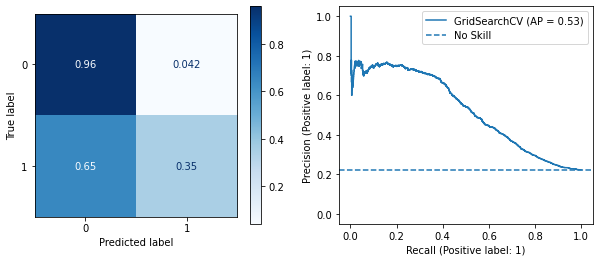

Support Vector Machine with PCA
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
Best validation score:	0.452377656956216
Test Scores:
- Accuracy:	0.8216457235508715
- Recall:	0.34948516050878253
- Precision:	0.701093560145808
- F1-score:	0.4664510913500404
- AUC:		0.5978471227918272


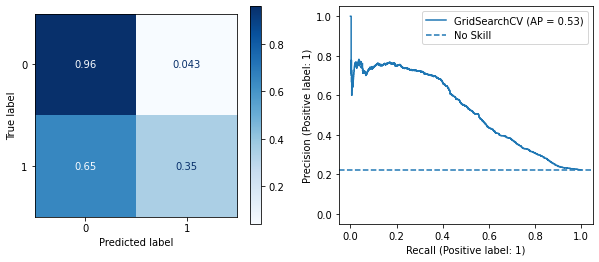

Support Vector Machine with PCA + SMOTE oversampling
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation score:	0.6755995088228721
Test Scores:
- Accuracy:	0.7698959600054047
- Recall:	0.5693519079345851
- Precision:	0.4865424430641822
- F1-score:	0.5246999720904271
- AUC:		0.5759812249521603


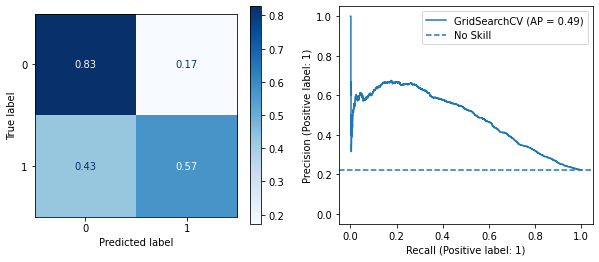

Support Vector Machine with PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation score:	0.762233620723567
Test Scores:
- Accuracy:	0.7470612079448723
- Recall:	0.49061175045427013
- Precision:	0.43997827267789247
- F1-score:	0.46391752577319584
- AUC:		0.5221116579652165


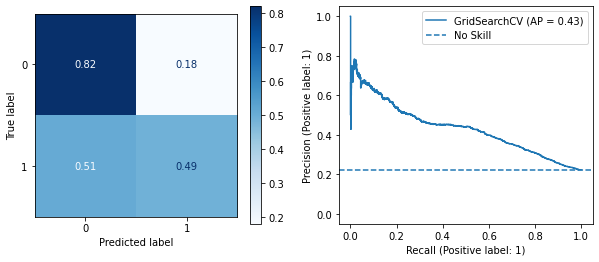

Support Vector Machine with PCA + ClusterCentroids oversampling
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters:	{'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}
Best validation score:	0.6906331188334175
Test Scores:
- Accuracy:	0.5705985677611134
- Recall:	0.7383403997577226
- Precision:	0.30744010088272383
- F1-score:	0.4341168091168091
- AUC:		0.5520754955573534


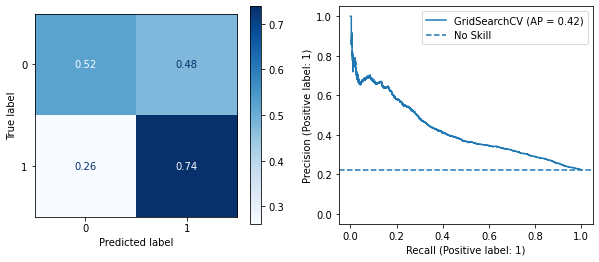

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.822186,0.350697,0.703524,0.468068,0.599533
PCA,0.821646,0.349485,0.701094,0.466451,0.597847
PCA + SMOTE oversampling,0.769896,0.569352,0.486542,0.524700,0.575981
PCA + KMeansSMOTE oversampling,0.747061,0.490612,0.439978,0.463918,0.522112
PCA + ClusterCentroids oversampling,0.570599,0.738340,0.307440,0.434117,0.552075


In [47]:
params_svm = {'C': [1e-1, 1e0, 1e1, 1e2], 
              'kernel': ['rbf', 'poly'], 
              'gamma': [1e-1, 'scale']}
for idx, oversample in enumerate(oversample_method):
    print(f"Support Vector Machine with {oversample_names[idx]}")
    _, scores = pipeline(SVC(),
                         params_svm,
                         oversample)
    scores_svm['Accuracy'][idx] = scores[0]
    scores_svm['Recall'][idx] = scores[1]
    scores_svm['Precision'][idx] = scores[2]
    scores_svm['F1-score'][idx] = scores[3]
    scores_svm['AUC'][idx] = scores[4]
    
scores_svm_df = pd.DataFrame(data=scores_svm, index=oversample_names)
scores_svm_df

The outputs above show that the Grid-Search usually selects the `rbf` kernel and a high value of `C`. This means that the model aims to correctly classify all training examples, rather than building a smooth decision boundary.

We can see in the dataframe that in this case not oversampling still leads to good results on the test set in terms of F1-score. We think it is due to the fact that the model needs few significant examples to be used as support vectors to build the decision boundary.

<a id='tree'></a>
## 5.3 Tree-Based Methods
Tree-based methods provide a simple, intuitive, and powerful mechanism for both regression and classification. The main idea is to *stratify* a (potentially complicated) feature space into smaller regions and fit a simple prediction function to each region [\[16\]](#kroese). In order to classify a given observation, we typically use the mode response value for the training observations in the region to which it belongs. Since the set of splitting rules used to segment the predictor space can be summarized in a tree, these types of approaches are known as *decision tree* methods [\[17\]](#james).

### 5.3.1 Decision Trees
Decision tree classifiers are attractive models if we care about interpretability. They involve creating a set of binary splits on the predictor variables in order to create a tree that can be used to classify new observations into one of two groups [\[21\]](#r-in-action).

Using the decision algorithm, we start at the tree root and split the data on the feature that results in the largest *information gain* (IG):
- if the predictor is continuous, we choose a cut-point that maximizes purity for the two groups created;
- if the predictor variable is categorical, we combine the categories to obtain two groups with maximum purity.

In an iterative process, we can then repeat this splitting procedure at each child node until the leaves are pure. This means that the training examples at each node all belong to the same class. Unfortunately, this process tends to produce a tree that is too large and suffers from overfitting. Thus, we typically prune the tree by setting a limit for the maximal depth of the tree.

Considering a binary decision tree, we define the IG at each split as follows:

$$IG(D_p, f)=I(D_p)-\sum_{j\in\{left,right\}}{\frac{N_{j}}{N_p}I(D_{j})}$$

- $f$ is the feature to perform the split;
- $D_p$ and $D_j$ are the dataset of the parent and $j$th child nodes;
- $I$ is our impurity measure;
- $N_p$ is the total number of training examples at the parent node, and $N_j$ is the number of examples in the $j$th child node.

Hence, the information gain is simply the difference between the impurity of the parent node and the sum of the child node impurities. In order to split the nodes at the most informative features, we need to maximize the IG at each split.

**Gini impurity** ($I_G$) and **entropy** ($I_H$) are the most commonly used splitting criteria in binary decision trees. Definying as $p(i|t)$ the proportion of the examples that belong to class $i$ for a particular node $t$, we can write the entropy as:

$$I_H(t)=-\sum_{i=1}^{c}{p(i|t)\log_2{p(i|t)}}$$

and the Gini impurity as:

$$I_G(t)=\sum_{i=1}^{c}{p(i|t)(1-p(i|t))}$$

Below we build a shallow decision tree using raw data from our dataset to show its interpretability. Since we are not going deep, the classes are still distributed uniformly at the terminal nodes (i.e., the *leaves*) and the entropy measure is very high.

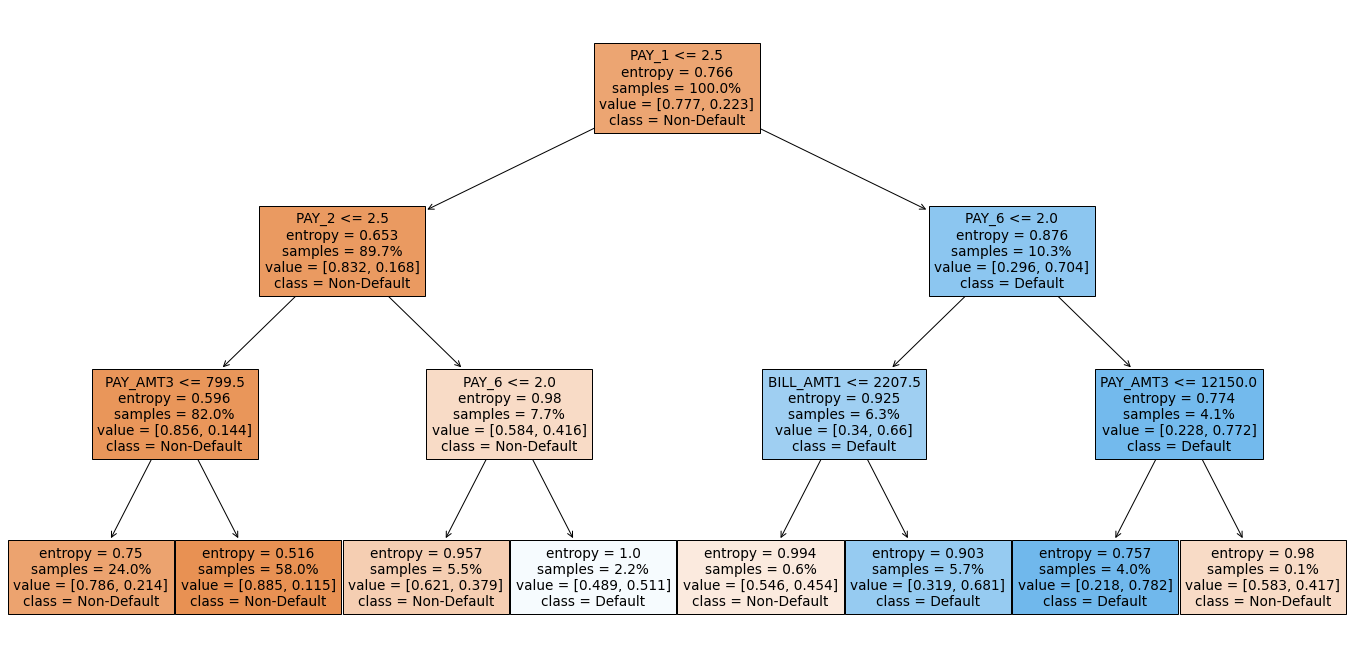

In [48]:
clf = DecisionTreeClassifier(max_depth=3, 
                             criterion='entropy', 
                             max_features=None)
clf.fit(X_train_raw, y_train)
plt.figure(figsize=(24,12))
tree.plot_tree(decision_tree=clf,
               feature_names=X_train_raw.columns, 
               class_names=['Non-Default','Default'],
               filled=True, proportion=True)
plt.show()

In practice, both Gini impurity and entropy typically yield very similar results. Hence, we think it is not worth spending much time on evaluating trees using different impurity criteria, and we rather experiment with different pruning cut-offs.

```python
params = {'max_depth': [5, 10, 20, 30, 50],
          'criterion': ['entropy']}
```

In [49]:
def plot_tree_test_scores(model, oversample, plot):
    if oversample == 'raw':
        X_test_s = X_test_raw.copy()
    else:
        X_test_s = X_test.copy()
    y_pred = model.predict(X_test_s)
    test_acc = accuracy_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_recall = recall_score(y_test, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
    test_auc = auc(recall, precision)
    test_f1 = f1_score(y_test, y_pred)
    
    print("Test Scores:")
    print(f"- Accuracy:\t{test_acc}")
    print(f"- Recall:\t{test_recall}")
    print(f"- Precision:\t{test_precision}")
    print(f"- F1-score:\t{test_f1}")
    print(f"- AUC:\t\t{test_auc}")
    
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(15,4))
        
        tmp = pd.DataFrame({'Feature': X_test_s.columns, 
                            'Feature importance': model.best_estimator_.feature_importances_})
        tmp = tmp.sort_values(by='Feature importance', ascending=False)
        s = sns.barplot(x='Feature', y='Feature importance', data=tmp, ax=axs[0])
        s.set_xticklabels(s.get_xticklabels(), rotation=90)
        
        plot_confusion_matrix(model, X_test_s, y_test, cmap=plt.cm.Blues, normalize='true', ax=axs[1])
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plot_precision_recall_curve(model, X_test_s, y_test, ax=axs[2])
        plt.axhline(no_skill, 0, ls='--', label='No Skill')
        plt.ylim([-0.05, 1.05])
        axs[2].legend(loc = 'upper right')
        plt.show()
    else:
        fig, axs = plt.subplots(1, 2, figsize=(10,4))
        plot_confusion_matrix(model, X_test_s, y_test, cmap=plt.cm.Blues, normalize='true', ax=axs[0])
        no_skill = len(y_test[y_test==1]) / len(y_test)
        plot_precision_recall_curve(model, X_test_s, y_test, ax=axs[1])
        plt.axhline(no_skill, 0, ls='--', label='No Skill')
        plt.ylim([-0.05, 1.05])
        axs[1].legend(loc = 'upper right')
        plt.show()
    
    return test_acc, test_recall, test_precision, test_f1, test_auc

def tree_pipeline(model, params, oversample=None, plot=False):
    if oversample:
        if oversample == 'raw':
            X_train_s = X_train_raw.copy()
            y_train_s = y_train.copy()  
        else:
            X_train_s, y_train_s = oversample.fit_resample(X_train, y_train)
    else:
        X_train_s = X_train.copy()
        y_train_s = y_train.copy()
    
    gs = GridSearchCV(estimator = model,
                      param_grid = params,
                      scoring = 'f1',
                      cv = 5, 
                      n_jobs = -1,
                      verbose = True)
    gs.fit(X_train_s, y_train_s)
    print(f"Best parameters:\t{gs.best_params_}")
    print(f"Best validation score:\t{gs.best_score_}")
    
    test_scores = plot_tree_test_scores(gs, oversample, plot)
    
    return gs.best_estimator_, test_scores

In [50]:
oversample_method = ['raw',
                     None, 
                     SMOTE(random_state=24),
                     KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=24),
                     ClusterCentroids(random_state=24)]
oversample_names = ['Raw data', 
                    'PCA', 
                    'PCA + SMOTE oversampling', 
                    'PCA + KMeansSMOTE oversampling', 
                    'PCA + ClusterCentroids oversampling']
scores_tree = {'Accuracy' : [float for i in range(len(oversample_method))],
             'Recall' : [float for i in range(len(oversample_method))],
             'Precision' : [float for i in range(len(oversample_method))], 
             'F1-score' : [float for i in range(len(oversample_method))],
             'AUC' : [float for i in range(len(oversample_method))],}

Decision Tree with Raw data
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 5}
Best validation score:	0.45813216221308634
Test Scores:
- Accuracy:	0.8205647885420889
- Recall:	0.35978195033313143
- Precision:	0.6867052023121387
- F1-score:	0.47217806041335453
- AUC:		0.5946528453403355


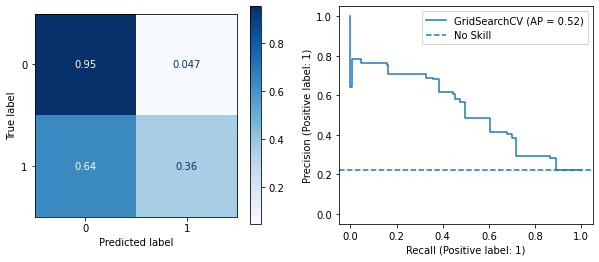

Decision Tree with PCA
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 10}
Best validation score:	0.430074611221572
Test Scores:
- Accuracy:	0.8078638021888934
- Recall:	0.3579648697758934
- Precision:	0.6201469045120671
- F1-score:	0.4539170506912442
- AUC:		0.5606678314758273


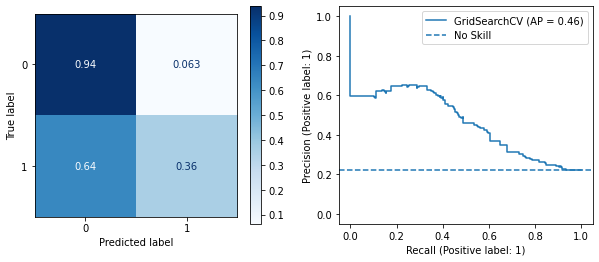

Decision Tree with PCA + SMOTE oversampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 30}
Best validation score:	0.761960051344928
Test Scores:
- Accuracy:	0.6815295230374274
- Recall:	0.4875832828588734
- Precision:	0.34758203799654575
- F1-score:	0.40584824804638264
- AUC:		0.4747370990170894


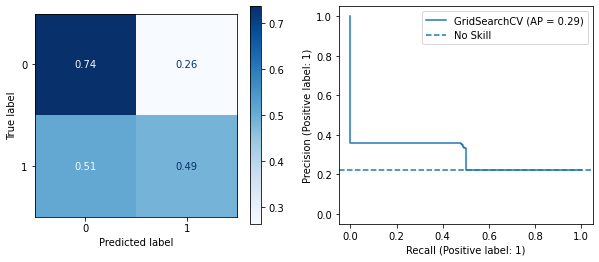

Decision Tree with PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 20}
Best validation score:	0.7830628858972355
Test Scores:
- Accuracy:	0.7459802729360897
- Recall:	0.42216838279830404
- Precision:	0.42945163277880466
- F1-score:	0.42577886377519847
- AUC:		0.4902607576872167


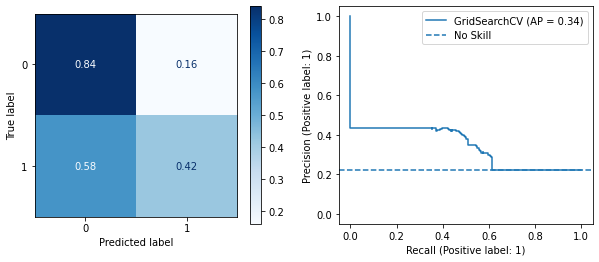

Decision Tree with PCA + ClusterCentroids oversampling
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters:	{'max_depth': 10}
Best validation score:	0.6578644813080733
Test Scores:
- Accuracy:	0.4965545196595055
- Recall:	0.660205935796487
- Precision:	0.25616921269095183
- F1-score:	0.36911615306468
- AUC:		0.4960878579891592


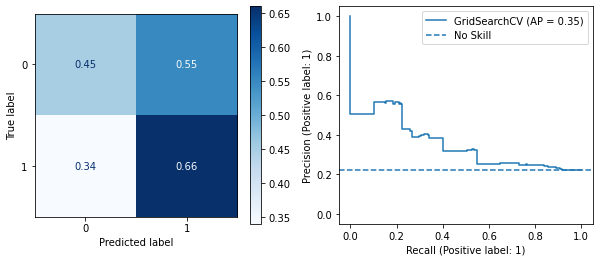

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.820565,0.359782,0.686705,0.472178,0.594653
PCA,0.807864,0.357965,0.620147,0.453917,0.560668
PCA + SMOTE oversampling,0.681530,0.487583,0.347582,0.405848,0.474737
PCA + KMeansSMOTE oversampling,0.745980,0.422168,0.429452,0.425779,0.490261
PCA + ClusterCentroids oversampling,0.496555,0.660206,0.256169,0.369116,0.496088


In [51]:
params_tree = {'max_depth': [5, 10, 20, 30, 50]}
for idx, oversample in enumerate(oversample_method):
    print(f"Decision Tree with {oversample_names[idx]}")
    _, scores = tree_pipeline(DecisionTreeClassifier(criterion='entropy', max_features=None, random_state=24),
                         params_tree,
                         oversample)
    scores_tree['Accuracy'][idx] = scores[0]
    scores_tree['Recall'][idx] = scores[1]
    scores_tree['Precision'][idx] = scores[2]
    scores_tree['F1-score'][idx] = scores[3]
    scores_tree['AUC'][idx] = scores[4]
    
scores_rf_tree = pd.DataFrame(data=scores_tree, index=oversample_names)
scores_rf_tree

The results reported in the dataframe above show that the decision tree works best with raw data. Having this baseline, we try to improve predictive performance by aggregating different decision trees in a random forest.

### 5.3.2 Random Forest
Decision trees are said to suffer from *high variance*, as if we randomly split the training data into two parts, and fit a decision tree on both halves, we could get quite different results [\[17\]](#james). We want to lower the variance of our model in order to obtain similar results if we apply it repeatedly on different datasets. It is possible to reduce the variance of a model by building an *ensemble* of several classifiers trained on different sets from a population, and averaging the resulting predictions. However, in our case we do not have access to multiple training sets, so we take repeated samples from our dataset to generate different *bootstrapped training sets*. In this way we can build several decision trees whose predictions we can aggregate with a *majority voting* procedure. This approach is called *bootstrap aggregating*, or **bagging**.

The major idea of **random forests** is to perform bagging in combination with a *decorrelation* of the trees. For each bootstrapped training set, we build a decision tree using a randomly selected *subset* of features for the splitting rules. Typically, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors. This simple but powerful idea will decorrelate the trees, since strong predictors will have a smaller chance to be considered at the root levels.

In the `RandomForestClassifier` implementation in Scikit-Learn, the size of the bootstrap sample is chosen to be equal to the number of training examples in the original training dataset, which usually provides a good
bias-variance tradeoff [\[4\]](#raschka). In our model selection procedure, we do not even have to worry about the depth of the trees, since the forest is quite robust to the noise from the single tree. We are rather interested in the number of trees that form the forest and the maximum number of features to consider when looking for the best split: if the latter number is `None`, we are not decorrelating the trees and we are performing bagging.

```python
params = {'n_estimators': [10, 50, 100, 200], 
          'max_features': [None, 'sqrt']}
```

In [52]:
oversample_method = ['raw',
                     None, 
                     SMOTE(random_state=24),
                     KMeansSMOTE(cluster_balance_threshold=1e-5, random_state=24),
                     ClusterCentroids(random_state=24)]
oversample_names = ['Raw data', 
                    'PCA', 
                    'PCA + SMOTE oversampling', 
                    'PCA + KMeansSMOTE oversampling', 
                    'PCA + ClusterCentroids oversampling']
scores_rf = {'Accuracy' : [float for i in range(len(oversample_method))],
             'Recall' : [float for i in range(len(oversample_method))],
             'Precision' : [float for i in range(len(oversample_method))], 
             'F1-score' : [float for i in range(len(oversample_method))],
             'AUC' : [float for i in range(len(oversample_method))],}

Random Forest with Raw data
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': None, 'n_estimators': 200}
Best validation score:	0.4695030676559674
Test Scores:
- Accuracy:	0.8209701391703824
- Recall:	0.39672925499697154
- Precision:	0.665650406504065
- F1-score:	0.49715370018975336
- AUC:		0.598478035047235


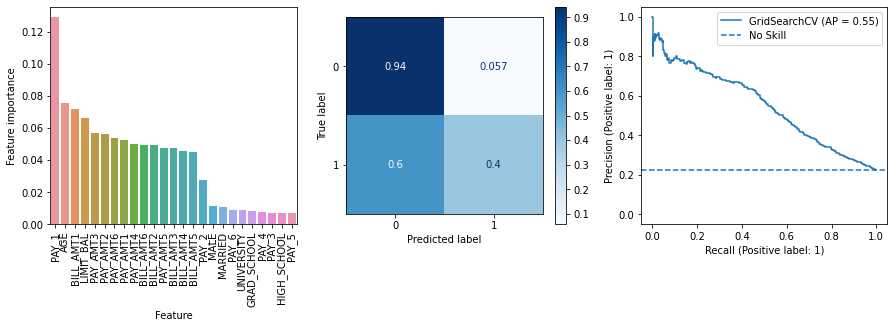

Random Forest with PCA
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': None, 'n_estimators': 200}
Best validation score:	0.4420222896481517
Test Scores:
- Accuracy:	0.8088096203215782
- Recall:	0.36644457904300426
- Precision:	0.6211498973305954
- F1-score:	0.4609523809523809
- AUC:		0.5644633643859621


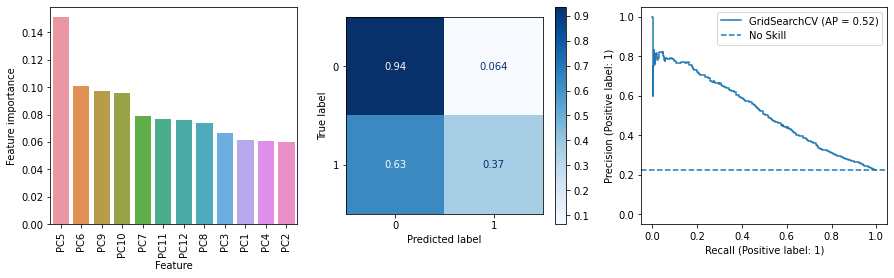

Random Forest with PCA + SMOTE oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': 'sqrt', 'n_estimators': 200}
Best validation score:	0.8348110891947279
Test Scores:
- Accuracy:	0.7635454668288069
- Recall:	0.5130224106602059
- Precision:	0.4723926380368098
- F1-score:	0.491869918699187
- AUC:		0.5470245085398333


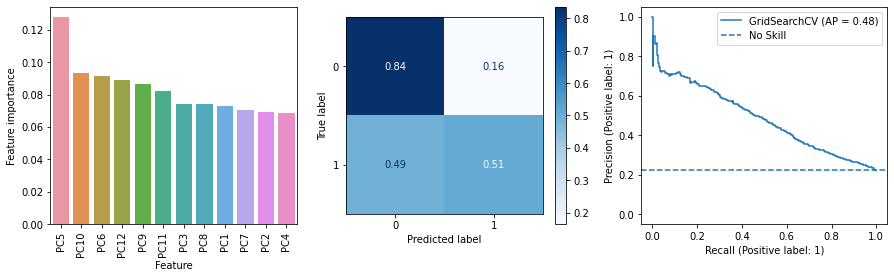

Random Forest with PCA + KMeansSMOTE oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': None, 'n_estimators': 50}
Best validation score:	0.81147089853369
Test Scores:
- Accuracy:	0.7836778813673828
- Recall:	0.41429436705027256
- Precision:	0.5189681335356601
- F1-score:	0.4607611990569215
- AUC:		0.5319602598862645


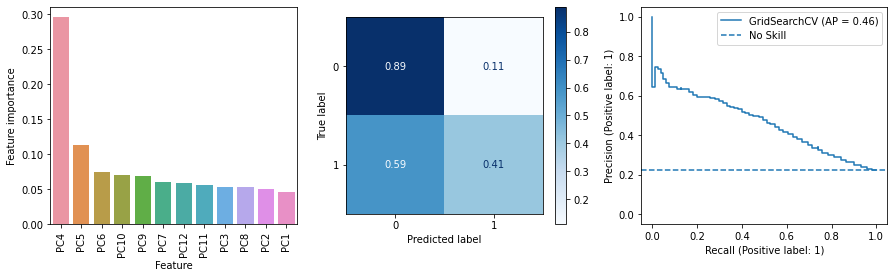

Random Forest with PCA + ClusterCentroids oversampling
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters:	{'max_features': 'sqrt', 'n_estimators': 100}
Best validation score:	0.6693272288123173
Test Scores:
- Accuracy:	0.5819483853533306
- Recall:	0.6656571774682011
- Precision:	0.3018401538039
- F1-score:	0.4153439153439153
- AUC:		0.5210409234390501


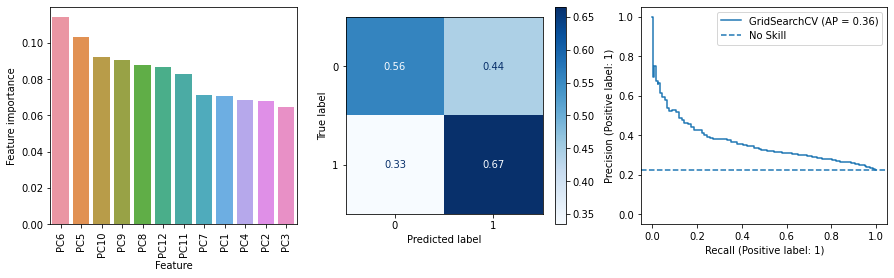

,Accuracy,Recall,Precision,F1-score,AUC
Raw data,0.820970,0.396729,0.665650,0.497154,0.598478
PCA,0.808810,0.366445,0.621150,0.460952,0.564463
PCA + SMOTE oversampling,0.763545,0.513022,0.472393,0.491870,0.547025
PCA + KMeansSMOTE oversampling,0.783678,0.414294,0.518968,0.460761,0.531960
PCA + ClusterCentroids oversampling,0.581948,0.665657,0.301840,0.415344,0.521041


In [53]:
params_rf = {'n_estimators': [10, 50, 100, 200], 
             'max_features': [None, 'sqrt']}
for idx, oversample in enumerate(oversample_method):
    print(f"Random Forest with {oversample_names[idx]}")
    _, scores = tree_pipeline(RandomForestClassifier(criterion='entropy', random_state=24, oob_score=True),
                         params_rf,
                         oversample,
                         True)
    scores_rf['Accuracy'][idx] = scores[0]
    scores_rf['Recall'][idx] = scores[1]
    scores_rf['Precision'][idx] = scores[2]
    scores_rf['F1-score'][idx] = scores[3]
    scores_rf['AUC'][idx] = scores[4]
    
scores_rf_df = pd.DataFrame(data=scores_rf, index=oversample_names)
scores_rf_df

The results reported in the dataframe above show that aggregating multiple trees in a forest leads to an overall improvement in prediction performance. Bagging and Random Forest models are not interpretable as individual decision trees. However, they allow us to measure and plot the feature importance as the averaged impurity decrease computed from all decision trees in the ensemble, without making any assumptions about whether our data are linearly separable or not.

In particular, we can refer to the Random Forest trained on raw data, as it offers a really useful features importance plot. When financial institutions consider issuing the client a credit card, they need to check the payment history of that person, because if he owes numerous bills already, he is likely to delay the payment of the current month. Besides the payment history, it is also imperative to look at the applicants' credit limit of their current credit cards. This is a result of a virtuous
circle: people who pay on duly tend to have better credit scores, so the banks prefer to increase these people's credit lines by taking less risk. Client's personal information also affects the default behavior, as it is collected by the banks when people apply for credit cards. However, we believe that financial institutions should equally consider their potential clients whether they are men or women, high school or university graduate, single or married, when decide whether approve their credit card applications.

<a id='results'></a>
## 5.4 Models' Performance Results
The dataframe below summarizes the results of the combination of different ML algorithms and oversampling techniques on the test set. The figure further down compares the F1-scores of the different models on the test set. We want to clarify that Logistic Regression and SVM did not work with true *raw* data, but with normalized data, unlike Decision Tree and Random Forest.

In [55]:
frames = [scores_lr_df, scores_svm_df, scores_rf_tree, scores_rf_df]
scores_df = pd.concat(frames, keys=['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest'])
scores_df

Accuracy  \
Logistic Regression    Raw data                             0.804756   
                       PCA                                  0.804216   
                       PCA + SMOTE oversampling             0.631942   
                       PCA + KMeansSMOTE oversampling       0.724767   
                       PCA + ClusterCentroids oversampling  0.598703   
Support Vector Machine Raw data                             0.822186   
                       PCA                                  0.821646   
                       PCA + SMOTE oversampling             0.769896   
                       PCA + KMeansSMOTE oversampling       0.747061   
                       PCA + ClusterCentroids oversampling  0.570599   
Decision Tree          Raw data                             0.820565   
                       PCA                                  0.807864   
                       PCA + SMOTE oversampling             0.681530   
                       PCA + KMeansSMOTE oversampling       0.745980   
                       PCA + ClusterCentroids oversampling  0.496555   
Random Forest          Raw data                             0.820970   
                       PCA                                  0.808810   
                       PCA + SMOTE oversampling             0.763545   
                       PCA + KMeansSMOTE oversampling       0.783678   
                       PCA + ClusterCentroids oversampling  0.581948   

                                                              Recall  \
Logistic Regression    Raw data                             0.193822   
                       PCA                                  0.192005   
                       PCA + SMOTE oversampling             0.679588   
                       PCA + KMeansSMOTE oversampling       0.363416   
                       PCA + ClusterCentroids oversampling  0.665051   
Support Vector Machine Raw data                             0.350697   
                       PCA                                  0.349485   
                       PCA + SMOTE oversampling             0.569352   
                       PCA + KMeansSMOTE oversampling       0.490612   
                       PCA + ClusterCentroids oversampling  0.738340   
Decision Tree          Raw data                             0.359782   
                       PCA                                  0.357965   
                       PCA + SMOTE oversampling             0.487583   
                       PCA + KMeansSMOTE oversampling       0.422168   
                       PCA + ClusterCentroids oversampling  0.660206   
Random Forest          Raw data                             0.396729   
                       PCA                                  0.366445   
                       PCA + SMOTE oversampling             0.513022   
                       PCA + KMeansSMOTE oversampling       0.414294   
                       PCA + ClusterCentroids oversampling  0.665657   

                                                            Precision  \
Logistic Regression    Raw data                              0.737327   
                       PCA                                   0.733796   
                       PCA + SMOTE oversampling              0.338257   
                       PCA + KMeansSMOTE oversampling        0.378310   
                       PCA + ClusterCentroids oversampling   0.312376   
Support Vector Machine Raw data                              0.703524   
                       PCA                                   0.701094   
                       PCA + SMOTE oversampling              0.486542   
                       PCA + KMeansSMOTE oversampling        0.439978   
                       PCA + ClusterCentroids oversampling   0.307440   
Decision Tree          Raw data                              0.686705   
                       PCA                                   0.620147   
                       PCA + SMOTE oversampling              0.347582   
            

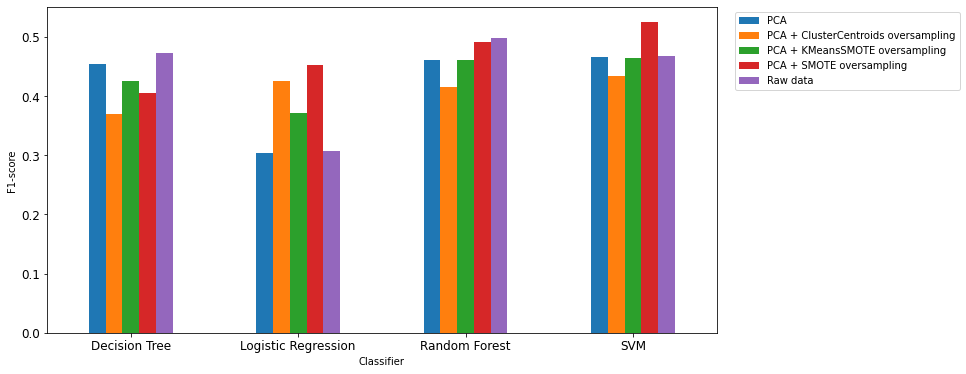

In [56]:
scores_lr_df['Classifier'] = 'Logistic Regression'
scores_lr_df['Technique'] = scores_lr_df.index
#scores_lr_df['Technique'][scores_lr_df['Technique']=='Normalized data'] = 'Raw data'
scores_svm_df['Classifier'] = 'SVM'
scores_svm_df['Technique'] = scores_svm_df.index
#scores_svm_df['Technique'][scores_svm_df['Technique']=='Normalized data'] = 'Raw data'
scores_rf_tree['Classifier'] = 'Decision Tree'
scores_rf_tree['Technique'] = scores_rf_tree.index
scores_rf_df['Classifier'] = 'Random Forest'
scores_rf_df['Technique'] = scores_rf_df.index

frames2 = [scores_lr_df, scores_svm_df, scores_rf_tree, scores_rf_df]
scores = pd.concat(frames2, ignore_index=True, keys=None)

scores.set_index(['Technique', 'Classifier']).unstack(0).plot(kind='bar', 
                                                              y='F1-score', 
                                                              ylabel='F1-score', 
                                                              figsize=(12,6), 
                                                              fontsize=12, 
                                                              rot=0).legend(bbox_to_anchor=(1.02, 1))

In general, oversampling improves predictive performance compared to undersampling. The original SMOTE algorithm works better than the novel version and allows to obtain the best model when used in conjuction with an SVM. However, we would like to acknowledge that the results of the random forest are remarkable. In fact, this model not only works well with raw data (second best overall), but also provides us with a ranking of the feature importances that can be useful to the financial institutions we are working for.

<a id='conclusion'></a>
# 6. Conclusion
Machine learning methods have been used in various domains, along with techniques for dealing with unbalanced datasets. The goal of this work has been to train different supervised learning algorithms to predict the client's behavior in paying off the credit card balance.

We conducted our study on the *Default of credit card clients* dataset. We investigated the dataset by using exploratory data analysis techniques. After cleaning the data, we applied data normalization and principal component analysis, in order to prepare the data to be fed to the machine learning algorithms. We started with the Logistic Regression model, then we got the best scores with a Support Vector Machine, and finally we obtained interpretable models using tree-based methods.

We tried our best to make a thorough analysis, but we cannot be satisfied with the results. Many algorithms have not been used and can be considered for future improvements. For instance, boosting models belong to the tree-based methods, and can be useful to financial institutions as they also provide a ranking of the feature importances. Moreover, starting from the idea that aggregating more trees in a forest improves predictive performance, we can create a voting classifier formed by an ensemble of different predictors, such as SVM, Random Forest, K-Nearest Neighbor, which together could be able to perform a stronger prediction.

Besides, the financial market changes rapidly every day, and people's economic status and performance are affected by the market all the time. Hence, we believe that if more economic indicators will be added to the dataset, this will leads to a more generic model.

<a id='references'></a>
# References
<a id='yeh2009'></a>[1] I-Cheng Yeh, Che-hui Lien, "The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients", Expert Systems with Applications, Volume 36, Issue 2, Part 1, 2009, Pages 2473-2480, ISSN 0957-4174. https://doi.org/10.1016/j.eswa.2007.12.020.<br>
<a id='uci'></a>[2] D. Dua and C. Graff, UCI Machine Learning Repository: default of credit card clients Data Set [https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients ], Irvine, CA: University of California, School of Information and Computer Science, 2019.<br>
<a id='alam2021'></a>[3] T. M. Alam et al., "An Investigation of Credit Card Default Prediction in the Imbalanced Datasets," in IEEE Access, vol. 8, pp. 201173-201198, 2020. https://doi.org/10.1109/ACCESS.2020.3033784.<br>
<a id='raschka'></a>[4] Sebastian Raschka, "Python Machine Learning", 3rd ed., Packt Publishing, 2019.<br>
<a id='chen2021'></a>[5] Ying Chen, Ruirui Zhang, "Research on Credit Card Default Prediction Based on k-Means SMOTE and BP Neural Network", Complexity, Volume 2021, Article ID 6618841, 13 pages, 2021. https://doi.org/10.1155/2021/6618841.<br>
<a id='shalev'></a>[6] S. Shalev-Shwartz and S. Ben-David, Understanding Machine Learning: From Theory to Algorithms, Cambridge: Cambridge University Press, 2014. https://doi.org/10.1017/CBO9781107298019.<br>
<a id='yen2009'></a>[7] Show-Jane Yen, Yue-Shi Lee, "Cluster-based under-sampling approaches for imbalanced data distributions", Expert Systems with Applications, Volume 36, Issue 3, Part 1, 2009, Pages 5718-5727, ISSN 0957-4174. https://doi.org/10.1016/j.eswa.2008.06.108.<br>
<a id='imbalanced_learn'></a>[8] G. Lemaitre, et al., "Imbalanced-learn: A Python Toolbox to Tackle the Curse of Imbalanced Datasets in Machine Learning", 2016. https://arxiv.org/abs/1609.06570.<br>
<a id='cc_img'></a> [9] Q. Zou, et al., "An Approach for Identifying Cytokines Based On a Novel Ensemble Classifier", BioMed research international, 2013. https://doi.org/10.1155/2013/686090.<br>
<a id='smote'></a> [10] N. V. Chawla, et al., "SMOTE: synthetic minority over-sampling technique", Journal of artificial intelligence research, 321-357, 2002. https://arxiv.org/abs/1106.1813.<br>
<a id='k-means-smote'></a> [11] F. Last, et al., "Oversampling for Imbalanced Learning Based on K-Means and SMOTE", Information Sciences, Volume 465, 2018. https://arxiv.org/abs/1711.00837.<br>
<a id='cv10'></a> [12] Ron Kohavi, "A study of cross-validation and bootstrap for accuracy estimation and model selection", IJCAI'95, Volume 2, 1137–1143, 1995. https://dl.acm.org/doi/10.5555/1643031.1643047.<br>
<a id='tan2016'></a> [13] P.N. Tan, et al., "Introduction to data mining", Pearson Education India, 2016.<br>
<a id='ch8'></a> [14] N. Japkowicz, "Assessment metrics for imbalanced learning", Imbalanced learning, 187-206, 2013. https://doi.org/10.1002/9781118646106.ch8.<br>
<a id='agresti'></a> [15] Alan Agresti, "An introduction to categorical data analysis", 3rd ed., John Wiley & Sons, 2018.<br>
<a id='kroese'></a> [16] D.P. Kroese, et al., "Data Science and Machine Learning: Mathematical and Statistical Methods", Chapman & Hall, 2019. https://people.smp.uq.edu.au/DirkKroese/DSML/.<br>
<a id='james'></a> [17] G. James, et al., "An Introduction to Statistical Learning", 2nd ed., Springer, 2021. https://www.statlearning.com/.<br>
<a id='sklearn'></a> [18] F. Pedregosa, et al., "Scikit-learn: Machine Learning in Python", Journal of Machine Learning Research, Volume 12, 2825-2830, 2011. https://scikit-learn.org/stable/.<br>
<a id='mohri'></a> [19] M. Mohri, et al., "Foundations of machine learning", MIT press, 2018. https://cs.nyu.edu/~mohri/mlbook/.<br>
<a id='smola'></a> [20] A. Smola, S.V.N. Vishwanathan, "Introduction to Machine Learning", 2008. https://alex.smola.org/drafts/thebook.pdf.<br>
<a id='r-in-action'></a> [21] Robert I. Kabacoff, "R in Action", 2nd ed., Manning Publications, 2015. http://www.cs.uni.edu/~jacobson/4772/week11/R_in_Action.pdf. <br>